In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy

# Check current working directory (optional)
print("Current working directory:", os.getcwd())

# Read the CSV file
df = pd.read_csv(r'/root/clean AAC concrete dataset large ratio.csv')

# Remove the row where the "Ref." column equals "[107]"
df = df[df["Ref."] != "[107]"]

# Define original feature columns and target columns
original_feature_cols = [
    "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3",
    "TiO2", "P2O5", "SrO", "Mn2O3", "MnO", "LOI", 
    "AL/B", "SH/SS", "Ms", "Ag/B", "W/B", "Sp/B",
    "Initial curing time (day)", "Initial curing temp (C)", 
    "Initial curing rest time (day)", "Final curing temp (C)", 
    "Concentration (M) NaOH"
]

target_cols = ["7d CS", "28d CS"]

# Drop unwanted columns: "MnO", "Initial curing time (day)", "Initial curing rest time (day)"
cols_to_drop = ["MnO", "Initial curing time (day)", "Initial curing rest time (day)"]
df = df.drop(columns=cols_to_drop)

# Update the feature columns list accordingly (remove dropped columns)
feature_cols = [
    "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3",
    "TiO2", "P2O5", "SrO", "Mn2O3", "LOI", 
    "AL/B", "SH/SS", "Ms", "Ag/B", "W/B", "Sp/B",
    "Initial curing temp (C)", "Final curing temp (C)", 
    "Concentration (M) NaOH"
]

# Convert target columns to numeric (replacing empty strings with NaN)
for col in target_cols:
    df[col] = pd.to_numeric(df[col].replace(' ', np.nan), errors='coerce')

# Print missing values in target columns
print("Missing values in target columns:")
print(df[target_cols].isnull().sum())

# Drop rows with missing target values
df_clean = df.dropna(subset=target_cols)
print(f"Dataset shape after dropping rows with missing targets: {df_clean.shape}")

# Fill missing values in specific feature columns using the median
df_clean["Na2O"] = df_clean["Na2O"].fillna(df_clean["Na2O"].median())
df_clean["Concentration (M) NaOH"] = df_clean["Concentration (M) NaOH"].fillna(df_clean["Concentration (M) NaOH"].median())

# Extract feature and target arrays BEFORE scaling
X = df_clean[feature_cols].values
y_7 = df_clean["7d CS"].values
y_28 = df_clean["28d CS"].values

print("X shape:", X.shape)
print("y_7 shape:", y_7.shape)
print("y_28 shape:", y_28.shape)

# Check missing values in the cleaned DataFrame
print("\nMissing values in cleaned DataFrame:")
print(df_clean[feature_cols + target_cols].isnull().sum())

Current working directory: /root
Missing values in target columns:
7d CS     621
28d CS    667
dtype: int64
Dataset shape after dropping rows with missing targets: (603, 73)
X shape: (603, 22)
y_7 shape: (603,)
y_28 shape: (603,)

Missing values in cleaned DataFrame:
SiO2                       0
Al2O3                      0
Fe2O3                      0
CaO                        0
MgO                        0
Na2O                       0
K2O                        0
SO3                        0
TiO2                       0
P2O5                       0
SrO                        0
Mn2O3                      0
LOI                        0
AL/B                       0
SH/SS                      0
Ms                         0
Ag/B                       0
W/B                        0
Sp/B                       0
Initial curing temp (C)    0
Final curing temp (C)      0
Concentration (M) NaOH     0
7d CS                      0
28d CS                     0
dtype: int64


/tmp/ipykernel_7768/709531187.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Na2O"] = df_clean["Na2O"].fillna(df_clean["Na2O"].median())
/tmp/ipykernel_7768/709531187.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Concentration (M) NaOH"] = df_clean["Concentration (M) NaOH"].fillna(df_clean["Concentration (M) NaOH"].median())



Dataset sizes after split:
Training: 482
Testing: 121

Feature scaling check:
Training data - mean (should be ~0): 1.1202740818076969e-18
Training data - std (should be ~1): 1.0000000000000009
Test data - mean: 0.01169884779036416
Test data - std: 1.011560309513322


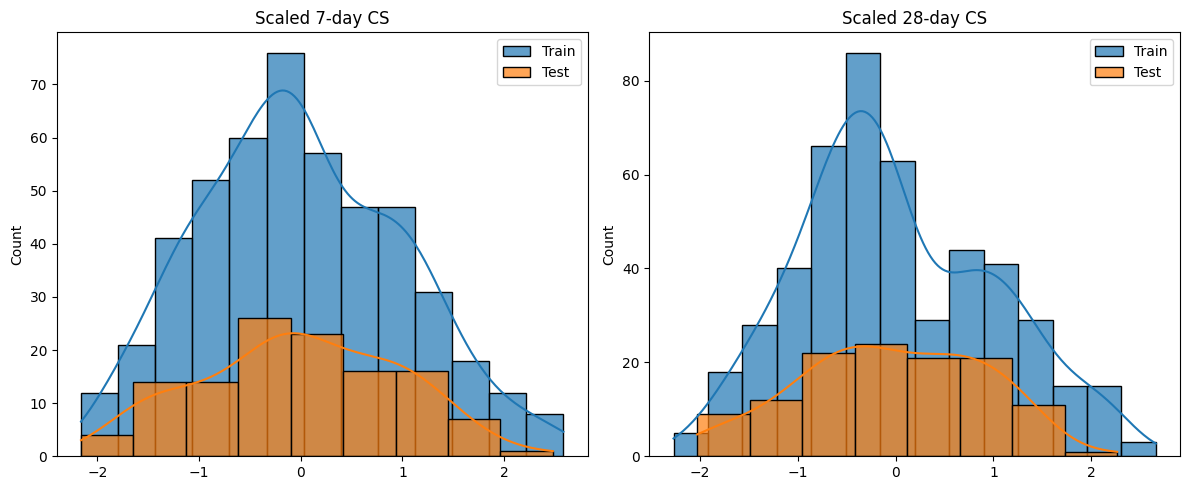


Using device: cuda


In [2]:
# =============================================================================
# IMPORTANT: Split data BEFORE scaling to avoid data leakage
# =============================================================================

# Split the unscaled data
X_train_full, X_test, y7_train_full, y7_test, y28_train_full, y28_test = train_test_split(
    X, y_7, y_28, test_size=0.2, random_state=42)

print("\nDataset sizes after split:")
print(f"Training: {len(X_train_full)}")
print(f"Testing: {len(X_test)}")

# =============================================================================
# Now scale the features using ONLY training data
# =============================================================================

# Fit the feature scaler on training data only
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_full)
X_test_scaled = feature_scaler.transform(X_test)  # Use the same scaler parameters

# Display summary statistics to check scaling
print("\nFeature scaling check:")
print("Training data - mean (should be ~0):", np.mean(X_train_scaled, axis=0).mean())
print("Training data - std (should be ~1):", np.std(X_train_scaled, axis=0).mean())
print("Test data - mean:", np.mean(X_test_scaled, axis=0).mean())
print("Test data - std:", np.std(X_test_scaled, axis=0).mean())

# =============================================================================
# Scale the targets using ONLY training data
# =============================================================================

# Create a DataFrame for training targets
train_targets_df = pd.DataFrame({
    "7d CS": y7_train_full,
    "28d CS": y28_train_full
})

# Initialize and fit a target scaler on TRAINING data only
target_scaler = StandardScaler()
train_targets_scaled = target_scaler.fit_transform(train_targets_df)

# Transform test targets using the same scaler
test_targets_df = pd.DataFrame({
    "7d CS": y7_test,
    "28d CS": y28_test
})
test_targets_scaled = target_scaler.transform(test_targets_df)

# Split the scaled targets into separate arrays
y7_train_scaled = train_targets_scaled[:, 0]
y28_train_scaled = train_targets_scaled[:, 1]
y7_test_scaled = test_targets_scaled[:, 0]
y28_test_scaled = test_targets_scaled[:, 1]

# Optional: Visualize the scaled target distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y7_train_scaled, kde=True, label='Train', alpha=0.7)
sns.histplot(y7_test_scaled, kde=True, label='Test', alpha=0.7)
plt.title("Scaled 7-day CS")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(y28_train_scaled, kde=True, label='Train', alpha=0.7)
sns.histplot(y28_test_scaled, kde=True, label='Test', alpha=0.7)
plt.title("Scaled 28-day CS")
plt.legend()

plt.tight_layout()
plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

In [3]:
# =============================================================================
# AGP Model Definition
# =============================================================================

class ConcreteDatasetScaled(Dataset):
    def __init__(self, features, y_7_scaled, y_28_scaled):
        self.z = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(np.vstack((y_7_scaled, y_28_scaled)).T, dtype=torch.float32)
        self.t = torch.tensor([7.0, 28.0], dtype=torch.float32)
    
    def __len__(self):
        return self.z.shape[0]
    
    def __getitem__(self, idx):
        return self.z[idx], self.t, self.y[idx]

class AGPModelGP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.1):
        super(AGPModelGP_v2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(hidden_dims[2], 5)
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        out = self.fc4(x)
        theta1 = self.softplus(out[:, 0])
        theta2 = out[:, 1]
        l = torch.exp(out[:, 2])
        sigma_f = torch.exp(out[:, 3])
        sigma_n = torch.exp(out[:, 4])
        return theta1, theta2, l, sigma_f, sigma_n

def gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, t, y, epsilon=1e-6):
    batch_size = y.shape[0]
    n_t = t.shape[0]
    total_nll = 0.0
    log_t = torch.log(t + epsilon)
    
    for i in range(batch_size):
        m = theta1[i] * log_t + theta2[i]
        diff = t.unsqueeze(0) - t.unsqueeze(1)
        K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
        K = K + sigma_n[i]**2 * torch.eye(n_t, device=K.device)
        K = K + epsilon * torch.eye(n_t, device=K.device)
        L_mat = torch.linalg.cholesky(K)
        diff_y = (y[i] - m).unsqueeze(1)
        alpha = torch.cholesky_solve(diff_y, L_mat)
        log_det_K = 2.0 * torch.sum(torch.log(torch.diag(L_mat)))
        nll = 0.5 * diff_y.t() @ alpha + 0.5 * log_det_K + 0.5 * n_t * np.log(2 * np.pi)
        total_nll += nll.squeeze()
    
    return total_nll / batch_size

In [4]:
# =============================================================================
# Training Function
# =============================================================================

def train_agp_model(model, train_loader, t, optimizer, num_epochs=300):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for z, _, y in train_loader:
            z, y = z.to(device), y.to(device)
            optimizer.zero_grad()
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            loss = gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, t.to(device), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 50 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Training NLL Loss: {avg_loss:.4f}")
    return model

# =============================================================================
# MC Dropout Inference
# =============================================================================

def mc_predict_with_uncertainty(model, dataloader, t, num_samples=50, epsilon=1e-6):
    model.train()  # Enable dropout during inference
    all_mc_means = []
    all_kernel_vars = []
    
    for z, _, y in dataloader:
        z = z.to(device)
        t_fixed_in = t.to(device)
        mc_sample_means = []
        mc_sample_vars = []
        
        for _ in range(num_samples):
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            m = theta1.unsqueeze(1) * torch.log(t_fixed_in + epsilon).unsqueeze(0) + theta2.unsqueeze(1)
            mc_sample_means.append(m.detach().cpu().numpy())
            
            batch_kernel_vars = []
            for i in range(z.size(0)):
                diff = t_fixed_in.unsqueeze(0) - t_fixed_in.unsqueeze(1)
                K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
                K = K + sigma_n[i]**2 * torch.eye(t_fixed_in.size(0), device=t_fixed_in.device)
                K = K + epsilon * torch.eye(t_fixed_in.size(0), device=t_fixed_in.device)
                K_inv = torch.linalg.inv(K)
                
                var_i = []
                for j in range(t_fixed_in.size(0)):
                    k_j = K[:, j].unsqueeze(1)
                    var_j = K[j, j] - (k_j.t() @ K_inv @ k_j).item()
                    var_i.append(float(max(var_j, 0)))
                batch_kernel_vars.append(var_i)
            
            mc_sample_vars.append(np.array(batch_kernel_vars))
        
        mc_sample_means = np.array(mc_sample_means)
        mc_sample_vars = np.array(mc_sample_vars)
        avg_kernel_vars = np.mean(mc_sample_vars, axis=0)
        all_mc_means.append(mc_sample_means)
        all_kernel_vars.append(avg_kernel_vars)
    
    mc_means = np.concatenate(all_mc_means, axis=1)
    mc_vars = np.concatenate(all_kernel_vars, axis=0)
    pred_mean = np.mean(mc_means, axis=0)
    pred_epistemic_var = np.var(mc_means, axis=0)
    pred_total_var = pred_epistemic_var + mc_vars
    
    return pred_mean, pred_total_var


--- Training AGP Model ---
Epoch 50/200, Training NLL Loss: 1.1121
Epoch 100/200, Training NLL Loss: 0.3992
Epoch 150/200, Training NLL Loss: 0.0807
Epoch 200/200, Training NLL Loss: -0.0741

--- MC Dropout Inference on Test Set ---

AGP Test R² for 7-day: 0.8180
AGP Test R² for 28-day: 0.7999


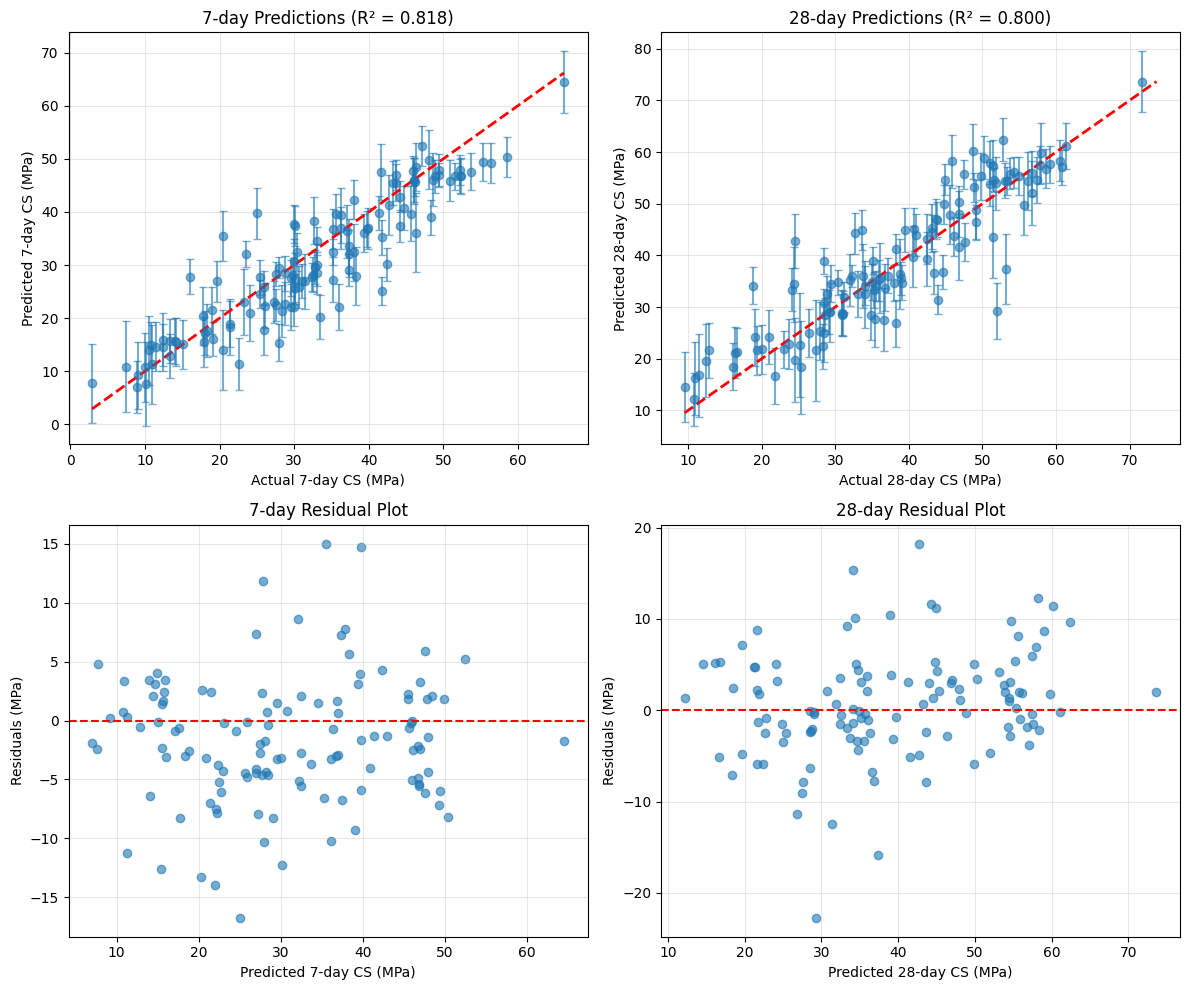


SUMMARY STATISTICS

7-day predictions:
  MAE: 4.37 MPa
  RMSE: 5.63 MPa
  R²: 0.8180
  Mean uncertainty (±2σ): 4.17 MPa

28-day predictions:
  MAE: 4.44 MPa
  RMSE: 5.97 MPa
  R²: 0.7999
  Mean uncertainty (±2σ): 4.62 MPa


In [5]:
# =============================================================================
# Create Datasets and DataLoaders
# =============================================================================

# Create datasets with properly scaled data
train_dataset_full = ConcreteDatasetScaled(X_train_scaled, y7_train_scaled, y28_train_scaled)
test_dataset_clean = ConcreteDatasetScaled(X_test_scaled, y7_test_scaled, y28_test_scaled)

# Create DataLoaders
train_loader_full = DataLoader(train_dataset_full, batch_size=len(train_dataset_full))
test_loader_clean = DataLoader(test_dataset_clean, batch_size=len(test_dataset_clean))

# =============================================================================
# Initialize and Train AGP Model
# =============================================================================

# Initialize model with best parameters
input_dim = X_train_scaled.shape[1]
best_dropout = 0.05
best_lr = 0.002
best_hidden_dims = [128, 128, 64]

model_agp = AGPModelGP_v2(input_dim, hidden_dims=best_hidden_dims, dropout_rate=best_dropout).to(device)
optimizer_agp = optim.Adam(model_agp.parameters(), lr=best_lr)
t_fixed = torch.tensor([7.0, 28.0], dtype=torch.float32)

print("\n--- Training AGP Model ---")
model_agp = train_agp_model(model_agp, train_loader_full, t_fixed, optimizer_agp, num_epochs=200)

# =============================================================================
# Perform MC Dropout Inference
# =============================================================================

print("\n--- MC Dropout Inference on Test Set ---")
mc_mean, mc_var = mc_predict_with_uncertainty(model_agp, test_loader_clean, t_fixed, num_samples=50)

# Convert predictions back to original scale
y_pred_original = target_scaler.inverse_transform(mc_mean)
std_scale = target_scaler.scale_
var_7_original = mc_var[:, 0] * (std_scale[0]**2)
var_28_original = mc_var[:, 1] * (std_scale[1]**2)
std_7_original = np.sqrt(var_7_original)
std_28_original = np.sqrt(var_28_original)

# Get ground truth in original scale (no need to inverse transform as they were never scaled)
y_true_7_original = y7_test
y_true_28_original = y28_test

# Calculate R² scores
r2_7_agp = r2_score(y_true_7_original, y_pred_original[:, 0])
r2_28_agp = r2_score(y_true_28_original, y_pred_original[:, 1])

print(f"\nAGP Test R² for 7-day: {r2_7_agp:.4f}")
print(f"AGP Test R² for 28-day: {r2_28_agp:.4f}")

# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: 7-day predictions vs actual
ax1 = axes[0, 0]
ax1.errorbar(y_true_7_original, y_pred_original[:, 0], 
             yerr=2*std_7_original, fmt='o', alpha=0.6, capsize=3)
min_val = min(y_true_7_original.min(), y_pred_original[:, 0].min())
max_val = max(y_true_7_original.max(), y_pred_original[:, 0].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax1.set_xlabel('Actual 7-day CS (MPa)')
ax1.set_ylabel('Predicted 7-day CS (MPa)')
ax1.set_title(f'7-day Predictions (R² = {r2_7_agp:.3f})')
ax1.grid(True, alpha=0.3)

# Plot 2: 28-day predictions vs actual
ax2 = axes[0, 1]
ax2.errorbar(y_true_28_original, y_pred_original[:, 1], 
             yerr=2*std_28_original, fmt='o', alpha=0.6, capsize=3)
min_val = min(y_true_28_original.min(), y_pred_original[:, 1].min())
max_val = max(y_true_28_original.max(), y_pred_original[:, 1].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax2.set_xlabel('Actual 28-day CS (MPa)')
ax2.set_ylabel('Predicted 28-day CS (MPa)')
ax2.set_title(f'28-day Predictions (R² = {r2_28_agp:.3f})')
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals for 7-day
ax3 = axes[1, 0]
residuals_7 = y_pred_original[:, 0] - y_true_7_original
ax3.scatter(y_pred_original[:, 0], residuals_7, alpha=0.6)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted 7-day CS (MPa)')
ax3.set_ylabel('Residuals (MPa)')
ax3.set_title('7-day Residual Plot')
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals for 28-day
ax4 = axes[1, 1]
residuals_28 = y_pred_original[:, 1] - y_true_28_original
ax4.scatter(y_pred_original[:, 1], residuals_28, alpha=0.6)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Predicted 28-day CS (MPa)')
ax4.set_ylabel('Residuals (MPa)')
ax4.set_title('28-day Residual Plot')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(f"\n7-day predictions:")
print(f"  MAE: {mean_absolute_error(y_true_7_original, y_pred_original[:, 0]):.2f} MPa")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true_7_original, y_pred_original[:, 0])):.2f} MPa")
print(f"  R²: {r2_7_agp:.4f}")
print(f"  Mean uncertainty (±2σ): {2*np.mean(std_7_original):.2f} MPa")

print(f"\n28-day predictions:")
print(f"  MAE: {mean_absolute_error(y_true_28_original, y_pred_original[:, 1]):.2f} MPa")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true_28_original, y_pred_original[:, 1])):.2f} MPa")
print(f"  R²: {r2_28_agp:.4f}")
print(f"  Mean uncertainty (±2σ): {2*np.mean(std_28_original):.2f} MPa")

In [6]:
# =============================================================================
# Alternative Scaling Methods with Proper Train-Test Split
# =============================================================================

# SOLUTION 1: Global Scaler (for both 7 and 28 day values)
def solution1_global_scaler(y7_train, y28_train, y7_test, y28_test):
    # Combine all TRAINING strengths
    all_train_strengths = np.concatenate([y7_train, y28_train])
    global_scaler = StandardScaler()
    global_scaler.fit(all_train_strengths.reshape(-1, 1))
    
    # Transform both train and test using the fitted scaler
    y7_train_scaled = global_scaler.transform(y7_train.reshape(-1, 1)).flatten()
    y28_train_scaled = global_scaler.transform(y28_train.reshape(-1, 1)).flatten()
    y7_test_scaled = global_scaler.transform(y7_test.reshape(-1, 1)).flatten()
    y28_test_scaled = global_scaler.transform(y28_test.reshape(-1, 1)).flatten()
    
    return y7_train_scaled, y28_train_scaled, y7_test_scaled, y28_test_scaled, global_scaler

# SOLUTION 2: Max Normalization
def solution2_normalize_by_max(y7_train, y28_train, y7_test, y28_test, max_strength=None):
    # If max_strength not provided, use the max from TRAINING data
    if max_strength is None:
        max_strength = max(y7_train.max(), y28_train.max())
    
    y7_train_scaled = y7_train / max_strength
    y28_train_scaled = y28_train / max_strength
    y7_test_scaled = y7_test / max_strength
    y28_test_scaled = y28_test / max_strength
    
    class MaxScaler:
        def __init__(self, max_val):
            self.max_val = max_val
            self.scale_ = np.array([max_val])  # For compatibility
        
        def inverse_transform(self, y):
            if len(y.shape) == 1:
                return y * self.max_val
            else:
                return y * self.max_val
    
    return y7_train_scaled, y28_train_scaled, y7_test_scaled, y28_test_scaled, MaxScaler(max_strength)

# Additional helper functions for continuous predictions
def predict_at_times(model, z, times, epsilon=1e-6):
    model.eval()
    with torch.no_grad():
        theta1, theta2, l, sigma_f, sigma_n = model(z)
        log_times = torch.log(times + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
    return means

def mc_predict_with_uncertainty_continuous(model, z_tensor, time_points, num_samples=50, epsilon=1e-6):
    model.train()  # Enable dropout
    mc_predictions = []
    
    for _ in range(num_samples):
        theta1, theta2, l, sigma_f, sigma_n = model(z_tensor)
        log_times = torch.log(time_points + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
        mc_predictions.append(means.detach().cpu().numpy())
    
    mc_predictions = np.array(mc_predictions)
    pred_mean = np.mean(mc_predictions, axis=0)
    pred_std = np.std(mc_predictions, axis=0)
    
    return pred_mean, pred_std

# Test both scaling methods
print("\n" + "="*60)
print("COMPARING DIFFERENT SCALING METHODS")
print("="*60)

solutions = [
    ("Separate Scalers (Original)", None, None),  # Already done above
    ("Global Scaler", solution1_global_scaler, None),
    ("Max Normalization (80 MPa)", solution2_normalize_by_max, 80.0),
    ("Max Normalization (Auto)", solution2_normalize_by_max, None)
]

results_comparison = []

for solution_name, scale_func, max_val in solutions:
    if solution_name == "Separate Scalers (Original)":
        # Use results from above
        results_comparison.append({
            'name': solution_name,
            'model': model_agp,
            'scaler': target_scaler,
            'r2_7': r2_7_agp,
            'r2_28': r2_28_agp,
            'mae_7': mean_absolute_error(y_true_7_original, y_pred_original[:, 0]),
            'mae_28': mean_absolute_error(y_true_28_original, y_pred_original[:, 1]),
            'predictions': y_pred_original,
            'uncertainties': np.column_stack([std_7_original, std_28_original])
        })
        continue
    
    print(f"\n{'='*50}")
    print(f"Testing {solution_name}")
    print('='*50)
    
    # Apply scaling
    if max_val is not None:
        y7_train_sc, y28_train_sc, y7_test_sc, y28_test_sc, scaler = scale_func(
            y7_train_full, y28_train_full, y7_test, y28_test, max_strength=max_val)
    else:
        y7_train_sc, y28_train_sc, y7_test_sc, y28_test_sc, scaler = scale_func(
            y7_train_full, y28_train_full, y7_test, y28_test)
    
    # Create datasets with the new scaling
    train_dataset = ConcreteDatasetScaled(X_train_scaled, y7_train_sc, y28_train_sc)
    test_dataset = ConcreteDatasetScaled(X_test_scaled, y7_test_sc, y28_test_sc)
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    
    # Initialize and train new model
    model = AGPModelGP_v2(input_dim, hidden_dims=[128, 128, 64], dropout_rate=0.05).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    
    # Train model
    model = train_agp_model(model, train_loader, t_fixed, optimizer, num_epochs=200)
    
    # MC Dropout predictions
    mc_mean, mc_var = mc_predict_with_uncertainty(model, test_loader, t_fixed, num_samples=50)
    
    # Inverse transform predictions
    if hasattr(scaler, 'inverse_transform'):
        pred_mean_orig = scaler.inverse_transform(mc_mean)
        if len(pred_mean_orig.shape) == 1:
            pred_mean_orig = pred_mean_orig.reshape(-1, 2)
        
        # Handle uncertainty scaling
        if hasattr(scaler, 'scale_'):
            if len(scaler.scale_) == 1:
                # Global scaler or max scaler
                std_orig = np.sqrt(mc_var) * scaler.scale_[0]
            else:
                # Separate scalers for each target
                std_orig = np.sqrt(mc_var) * scaler.scale_
        else:
            std_orig = np.sqrt(mc_var)
    
    # Calculate metrics
    r2_7 = r2_score(y7_test, pred_mean_orig[:, 0])
    r2_28 = r2_score(y28_test, pred_mean_orig[:, 1])
    mae_7 = mean_absolute_error(y7_test, pred_mean_orig[:, 0])
    mae_28 = mean_absolute_error(y28_test, pred_mean_orig[:, 1])
    
    print(f"\nResults for {solution_name}:")
    print(f"R² (7-day): {r2_7:.4f}")
    print(f"R² (28-day): {r2_28:.4f}")
    print(f"MAE (7-day): {mae_7:.2f} MPa")
    print(f"MAE (28-day): {mae_28:.2f} MPa")
    
    # Store results
    results_comparison.append({
        'name': solution_name,
        'model': model,
        'scaler': scaler,
        'r2_7': r2_7,
        'r2_28': r2_28,
        'mae_7': mae_7,
        'mae_28': mae_28,
        'predictions': pred_mean_orig,
        'uncertainties': std_orig
    })


COMPARING DIFFERENT SCALING METHODS

Testing Global Scaler
Epoch 50/200, Training NLL Loss: 0.7103
Epoch 100/200, Training NLL Loss: -0.4141
Epoch 150/200, Training NLL Loss: -0.7086
Epoch 200/200, Training NLL Loss: -0.9766

Results for Global Scaler:
R² (7-day): 0.7951
R² (28-day): 0.7621
MAE (7-day): 4.31 MPa
MAE (28-day): 4.52 MPa

Testing Max Normalization (80 MPa)
Epoch 50/200, Training NLL Loss: -1.6765
Epoch 100/200, Training NLL Loss: -3.4303
Epoch 150/200, Training NLL Loss: -3.8240
Epoch 200/200, Training NLL Loss: -4.0907

Results for Max Normalization (80 MPa):
R² (7-day): 0.8200
R² (28-day): 0.7962
MAE (7-day): 4.17 MPa
MAE (28-day): 4.35 MPa

Testing Max Normalization (Auto)
Epoch 50/200, Training NLL Loss: -1.5893
Epoch 100/200, Training NLL Loss: -2.5150
Epoch 150/200, Training NLL Loss: -2.9260
Epoch 200/200, Training NLL Loss: -3.0556

Results for Max Normalization (Auto):
R² (7-day): 0.7561
R² (28-day): 0.7351
MAE (7-day): 4.80 MPa
MAE (28-day): 4.96 MPa


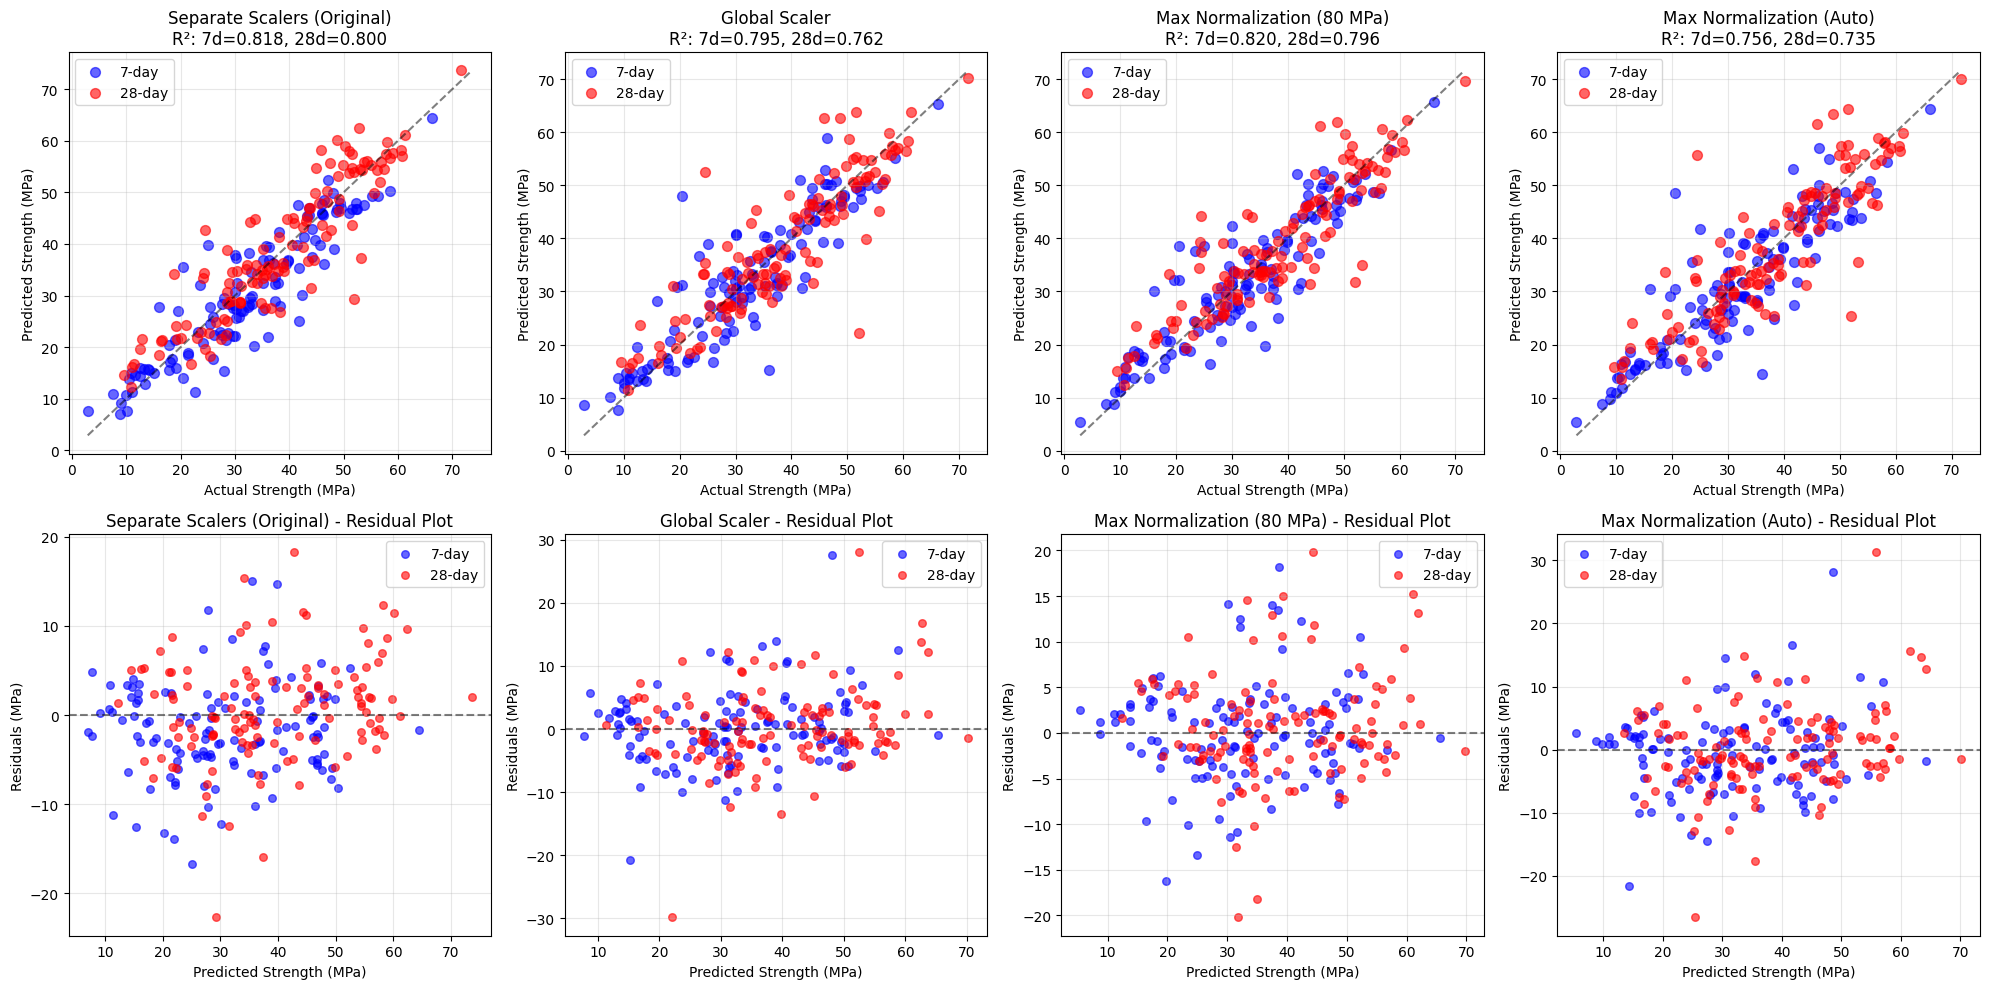

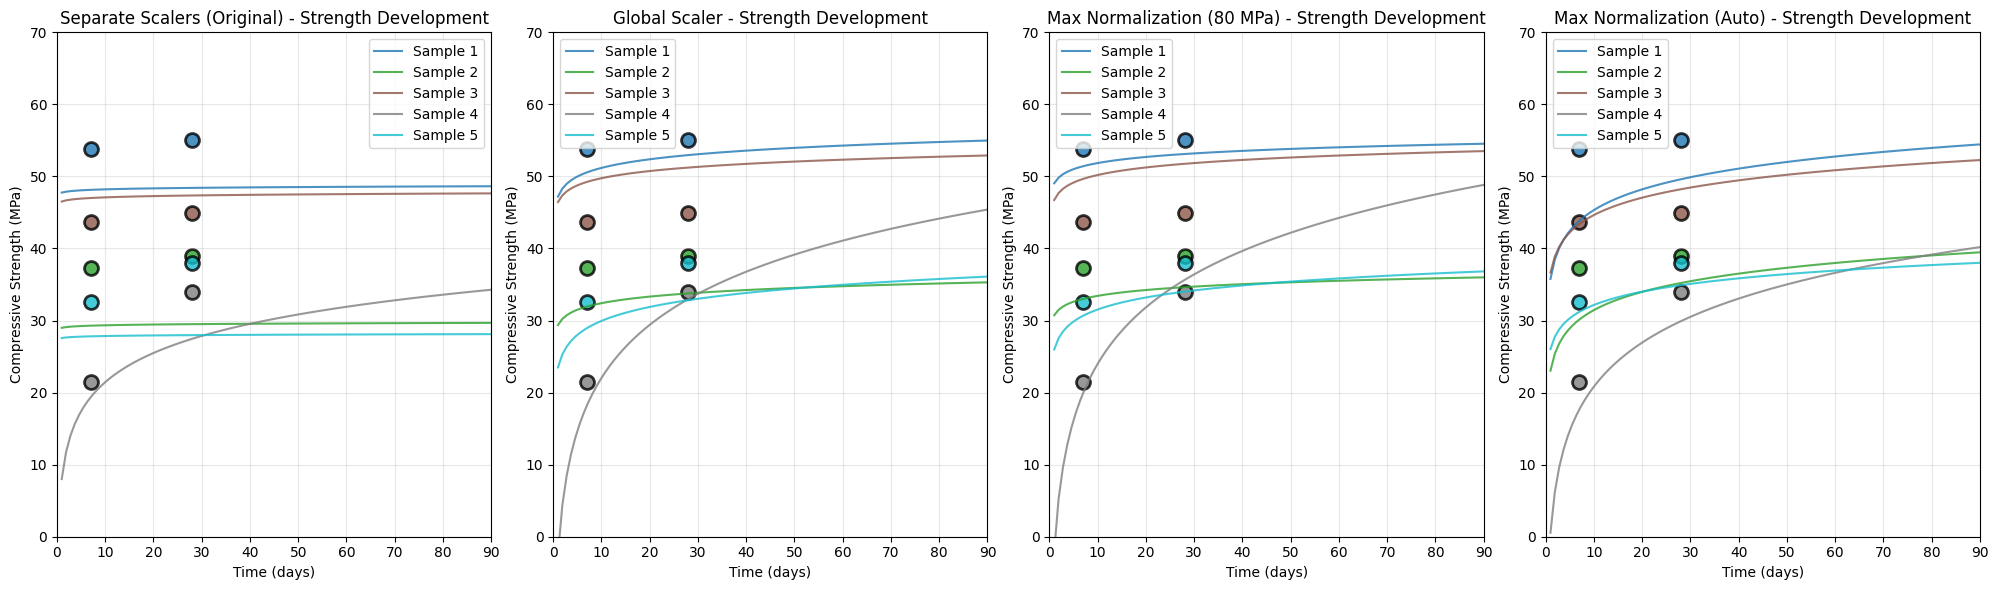


COMPARISON SUMMARY
Method                         |    R² 7d |   R² 28d |   MAE 7d |  MAE 28d
--------------------------------------------------------------------------------
Separate Scalers (Original)    |   0.8180 |   0.7999 |     4.37 |     4.44
Global Scaler                  |   0.7951 |   0.7621 |     4.31 |     4.52
Max Normalization (80 MPa)     |   0.8200 |   0.7962 |     4.17 |     4.35
Max Normalization (Auto)       |   0.7561 |   0.7351 |     4.80 |     4.96

DETAILED STATISTICS

Separate Scalers (Original):
----------------------------------------
  7-day:  R² = 0.8180, MAE = 4.37 MPa, RMSE = 5.63 MPa, Mean ±2σ = 4.17 MPa
  28-day: R² = 0.7999, MAE = 4.44 MPa, RMSE = 5.97 MPa, Mean ±2σ = 4.62 MPa

Global Scaler:
----------------------------------------
  7-day:  R² = 0.7951, MAE = 4.31 MPa, RMSE = 5.98 MPa, Mean ±2σ = 4.48 MPa
  28-day: R² = 0.7621, MAE = 4.52 MPa, RMSE = 6.51 MPa, Mean ±2σ = 4.79 MPa

Max Normalization (80 MPa):
----------------------------------------
 

In [10]:
# =============================================================================
# Visualization of Comparison Results
# =============================================================================

# Create comparison plots
fig = plt.figure(figsize=(20, 10))

# Select samples to visualize
n_samples_to_plot = 5
sample_indices = np.random.choice(len(X_test_scaled), n_samples_to_plot, replace=False)

for idx, result in enumerate(results_comparison):
    # Plot predictions vs actual
    ax = plt.subplot(2, len(results_comparison), idx + 1)
    
    # 7-day predictions
    ax.scatter(y7_test, result['predictions'][:, 0], 
               alpha=0.6, label='7-day', s=50, color='blue')
    # 28-day predictions
    ax.scatter(y28_test, result['predictions'][:, 1], 
               alpha=0.6, label='28-day', s=50, color='red')
    
    # Perfect prediction line
    all_actual = np.concatenate([y7_test, y28_test])
    all_pred = np.concatenate([result['predictions'][:, 0], result['predictions'][:, 1]])
    min_val = min(all_actual.min(), all_pred.min())
    max_val = max(all_actual.max(), all_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax.set_xlabel('Actual Strength (MPa)')
    ax.set_ylabel('Predicted Strength (MPa)')
    ax.set_title(f'{result["name"]}\nR²: 7d={result["r2_7"]:.3f}, 28d={result["r2_28"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot residuals
    ax2 = plt.subplot(2, len(results_comparison), idx + 1 + len(results_comparison))
    
    residuals_7 = result['predictions'][:, 0] - y7_test
    residuals_28 = result['predictions'][:, 1] - y28_test
    
    ax2.scatter(result['predictions'][:, 0], residuals_7, 
                alpha=0.6, label='7-day', s=30, color='blue')
    ax2.scatter(result['predictions'][:, 1], residuals_28, 
                alpha=0.6, label='28-day', s=30, color='red')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    ax2.set_xlabel('Predicted Strength (MPa)')
    ax2.set_ylabel('Residuals (MPa)')
    ax2.set_title(f'{result["name"]} - Residual Plot')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create strength development curves for selected samples
fig2 = plt.figure(figsize=(20, 6))

for idx, result in enumerate(results_comparison):
    ax = plt.subplot(1, len(results_comparison), idx + 1)
    
    # Generate predictions for continuous time range
    time_range = torch.linspace(1, 90, 100).to(device)
    z_samples = torch.tensor(X_test_scaled[sample_indices], dtype=torch.float32).to(device)
    
    # Get predictions without uncertainty for clarity
    pred_mean_cont = predict_at_times(result['model'], z_samples, time_range).cpu().numpy()
    
    # Inverse transform
    if hasattr(result['scaler'], 'inverse_transform'):
        if hasattr(result['scaler'], 'scale_') and len(result['scaler'].scale_) == 1:
            # Global or max scaler - reshape to 2D for inverse_transform
            pred_mean_flat = pred_mean_cont.flatten().reshape(-1, 1)
            pred_mean_cont_orig = result['scaler'].inverse_transform(pred_mean_flat).flatten().reshape(n_samples_to_plot, -1)
        else:
            # Separate scalers - need to handle each time point properly
            # For StandardScaler with 2 outputs, we need to be careful
            # Since we're predicting continuous time, we'll use the scale from the first output
            pred_mean_cont_orig = pred_mean_cont * result['scaler'].scale_[0] + result['scaler'].mean_[0]
    
    time_range_np = time_range.cpu().numpy()
    colors = plt.cm.tab10(np.linspace(0, 1, n_samples_to_plot))
    
    # Plot each sample
    for i in range(n_samples_to_plot):
        ax.plot(time_range_np, pred_mean_cont_orig[i], 
                label=f'Sample {i+1}', alpha=0.8, color=colors[i])
        
        # Plot actual values
        actual_7 = y7_test[sample_indices[i]]
        actual_28 = y28_test[sample_indices[i]]
        ax.scatter([7, 28], [actual_7, actual_28], s=100, alpha=0.8, 
                   edgecolors='black', color=colors[i], linewidth=2)
    
    ax.set_title(f'{result["name"]} - Strength Development')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Compressive Strength (MPa)')
    ax.set_xlim(0, 90)
    ax.set_ylim(0, max(70, np.max(y28_test[sample_indices]) * 1.1))
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# Summary Table
# =============================================================================

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"{'Method':<30} | {'R² 7d':>8} | {'R² 28d':>8} | {'MAE 7d':>8} | {'MAE 28d':>8}")
print("-"*80)

for result in results_comparison:
    print(f"{result['name']:<30} | {result['r2_7']:>8.4f} | {result['r2_28']:>8.4f} | "
          f"{result['mae_7']:>8.2f} | {result['mae_28']:>8.2f}")

print("\n" + "="*80)
print("DETAILED STATISTICS")
print("="*80)

for result in results_comparison:
    print(f"\n{result['name']}:")
    print("-" * 40)
    
    # Calculate additional metrics
    rmse_7 = np.sqrt(mean_squared_error(y7_test, result['predictions'][:, 0]))
    rmse_28 = np.sqrt(mean_squared_error(y28_test, result['predictions'][:, 1]))
    
    if result['uncertainties'].ndim == 1:
        mean_unc_7 = np.mean(result['uncertainties'])
        mean_unc_28 = np.mean(result['uncertainties'])
    else:
        mean_unc_7 = np.mean(result['uncertainties'][:, 0])
        mean_unc_28 = np.mean(result['uncertainties'][:, 1])
    
    print(f"  7-day:  R² = {result['r2_7']:.4f}, MAE = {result['mae_7']:.2f} MPa, "
          f"RMSE = {rmse_7:.2f} MPa, Mean ±2σ = {2*mean_unc_7:.2f} MPa")
    print(f"  28-day: R² = {result['r2_28']:.4f}, MAE = {result['mae_28']:.2f} MPa, "
          f"RMSE = {rmse_28:.2f} MPa, Mean ±2σ = {2*mean_unc_28:.2f} MPa")

# Save the best model
best_idx = np.argmax([r['r2_7'] + r['r2_28'] for r in results_comparison])
best_result = results_comparison[best_idx]
print(f"\nBest overall model: {best_result['name']}")
print(f"Combined R² score: {best_result['r2_7'] + best_result['r2_28']:.4f}")

# Optional: Save the model
# torch.save({
#     'model_state_dict': best_result['model'].state_dict(),
#     'scaler': best_result['scaler'],
#     'feature_scaler': feature_scaler,
#     'feature_cols': feature_cols,
#     'model_config': {
#         'input_dim': input_dim,
#         'hidden_dims': [128, 128, 64],
#         'dropout_rate': 0.05
#     }
# }, 'best_agp_model.pth')

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# THEORETICAL FRAMEWORK FOR UNCERTAINTY QUANTIFICATION
# =============================================================================
"""
UNCERTAINTY QUANTIFICATION IN AGP MODEL WITH MC-DROPOUT AND GP

The AGP model combines neural networks (with MC-Dropout) and Gaussian Processes.
This allows us to capture two types of uncertainty:

1. EPISTEMIC UNCERTAINTY (Model Uncertainty):
   - Captured through MC-Dropout sampling
   - Represents uncertainty in the neural network parameters (θ1, θ2, l, σf, σn)
   - Computed as the variance of predictions across MC samples
   - Can be reduced with more training data

2. ALEATORIC UNCERTAINTY (Data Noise):
   - Captured through the GP posterior variance
   - Represents inherent noise in the data
   - Includes both the noise term (σn²) and the GP predictive variance
   - Cannot be reduced with more data

3. TOTAL PREDICTIVE UNCERTAINTY:
   - For each MC sample i: Total_Var_i = GP_posterior_variance_i
   - Across MC samples: Total_Var = E[GP_posterior_variance] + Var[mean_predictions]
   - This properly accounts for both sources of uncertainty

4. 95% PREDICTION INTERVALS:
   - Lower/Upper = mean ± 1.96 × sqrt(total_variance)
   - Should contain approximately 95% of test observations
"""

# =============================================================================
# Enhanced MC-Dropout Prediction with Proper GP Uncertainty
# =============================================================================

def mc_predict_with_uncertainty_decomposed(model, dataloader, t, num_samples=100, epsilon=1e-6):
    """
    Perform MC-Dropout predictions with proper uncertainty decomposition.
    
    The key insight is that each MC sample gives us:
    1. A mean prediction (from θ1, θ2)
    2. A GP posterior variance (from l, σf, σn)
    
    The total uncertainty combines:
    - Variance across mean predictions (epistemic)
    - Average GP posterior variance (aleatoric)
    """
    model.train()  # Enable dropout
    device = next(model.parameters()).device
    
    all_mc_means = []
    all_mc_variances = []
    all_gp_params = []
    
    with torch.no_grad():
        for z, _, y in dataloader:
            z = z.to(device)
            t_fixed = t.to(device)
            batch_size = z.shape[0]
            n_times = t_fixed.shape[0]
            
            # Storage for this batch
            batch_means = np.zeros((num_samples, batch_size, n_times))
            batch_vars = np.zeros((num_samples, batch_size, n_times))
            
            for mc_idx in range(num_samples):
                # Forward pass with dropout
                theta1, theta2, l, sigma_f, sigma_n = model(z)
                
                # Compute mean predictions
                log_t = torch.log(t_fixed + epsilon)
                means = theta1.unsqueeze(1) * log_t.unsqueeze(0) + theta2.unsqueeze(1)
                batch_means[mc_idx] = means.cpu().numpy()
                
                # Compute GP posterior variance for each sample
                for i in range(batch_size):
                    # Build covariance matrix K
                    t_diff = t_fixed.unsqueeze(0) - t_fixed.unsqueeze(1)
                    K = sigma_f[i]**2 * torch.exp(-0.5 * t_diff**2 / l[i]**2)
                    K += sigma_n[i]**2 * torch.eye(n_times, device=device)
                    K += epsilon * torch.eye(n_times, device=device)  # numerical stability
                    
                    # Since we're predicting at the training time points,
                    # the posterior variance is the diagonal of the posterior covariance
                    # For exact computation at training points: Var = σn²
                    # For general points: Var = k** - k*ᵀ K⁻¹ k*
                    
                    # Here we use the full GP posterior variance
                    try:
                        L = torch.linalg.cholesky(K)
                        # For prediction at the same points as training
                        # Posterior variance ≈ noise variance for well-conditioned problems
                        # But we'll compute the full form for generality
                        
                        # Diagonal of K (prior variance at each point)
                        k_diag = sigma_f[i]**2 + sigma_n[i]**2
                        
                        # For each time point, compute reduction in variance
                        for j in range(n_times):
                            k_star = K[j, :].unsqueeze(0)  # covariance with all points
                            # Solve L L^T alpha = k_star^T
                            alpha = torch.cholesky_solve(k_star.t(), L)
                            # Posterior variance = prior variance - reduction
                            var_reduction = (k_star @ alpha).item()
                            posterior_var = k_diag - var_reduction + sigma_n[i]**2  # add back noise
                            batch_vars[mc_idx, i, j] = max(posterior_var.item(), epsilon)
                    except:
                        # If Cholesky fails, use simple noise variance
                        batch_vars[mc_idx, i, :] = sigma_n[i].item()**2
                
                # Store GP parameters for analysis
                all_gp_params.append({
                    'theta1': theta1.cpu().numpy(),
                    'theta2': theta2.cpu().numpy(),
                    'l': l.cpu().numpy(),
                    'sigma_f': sigma_f.cpu().numpy(),
                    'sigma_n': sigma_n.cpu().numpy()
                })
            
            all_mc_means.append(batch_means)
            all_mc_variances.append(batch_vars)
    
    # Combine all batches
    mc_means = np.concatenate([m.transpose(1, 0, 2) for m in all_mc_means], axis=0)
    mc_variances = np.concatenate([v.transpose(1, 0, 2) for v in all_mc_variances], axis=0)
    
    # Compute uncertainty components
    # Mean prediction (average across MC samples)
    pred_mean = np.mean(mc_means, axis=1)
    
    # Epistemic uncertainty: variance of mean predictions
    epistemic_var = np.var(mc_means, axis=1)
    
    # Aleatoric uncertainty: average of GP variances
    aleatoric_var = np.mean(mc_variances, axis=1)
    
    # Total predictive variance
    total_var = epistemic_var + aleatoric_var
    
    # Also compute the full predictive distribution statistics
    # For each test point, we have a mixture of Gaussians (one per MC sample)
    # The variance of this mixture is computed correctly above
    
    return {
        'mean': pred_mean,
        'epistemic_var': epistemic_var,
        'aleatoric_var': aleatoric_var,
        'total_var': total_var,
        'mc_means': mc_means,
        'mc_variances': mc_variances,
        'gp_params': all_gp_params
    }

# =============================================================================
# Prediction Interval Functions
# =============================================================================

def compute_prediction_intervals(mean, variance, confidence=0.95):
    """
    Compute prediction intervals assuming Gaussian distribution.
    
    For 95% confidence: mean ± 1.96 × std
    """
    z_score = stats.norm.ppf((1 + confidence) / 2)
    std = np.sqrt(variance)
    lower = mean - z_score * std
    upper = mean + z_score * std
    return lower, upper

def evaluate_prediction_intervals(y_true, y_pred, lower, upper, name=""):
    """
    Comprehensive evaluation of prediction intervals.
    """
    # Coverage
    in_interval = (y_true >= lower) & (y_true <= upper)
    coverage = np.mean(in_interval) * 100
    
    # Interval width
    widths = upper - lower
    mean_width = np.mean(widths)
    
    # Interval score (Gneiting & Raftery, 2007)
    # Penalizes both width and coverage errors
    alpha = 0.05  # for 95% intervals
    score = widths + (2/alpha) * (lower - y_true) * (y_true < lower) + \
            (2/alpha) * (y_true - upper) * (y_true > upper)
    mean_score = np.mean(score)
    
    # PICP (Prediction Interval Coverage Probability)
    picp = coverage / 100
    
    # MPIW (Mean Prediction Interval Width) 
    mpiw = mean_width
    
    # CWC (Coverage Width Criterion)
    mu = 0.95  # target coverage
    eta = 50   # penalty strength
    if picp < mu:
        cwc = mpiw * (1 + np.exp(eta * (mu - picp)))
    else:
        cwc = mpiw
    
    results = {
        'coverage': coverage,
        'mean_width': mean_width,
        'interval_score': mean_score,
        'picp': picp,
        'mpiw': mpiw,
        'cwc': cwc,
        'in_interval': in_interval
    }
    
    print(f"\n{name} Prediction Interval Metrics:")
    print(f"  Coverage: {coverage:.1f}% (target: 95%)")
    print(f"  Mean Width: {mean_width:.2f}")
    print(f"  Interval Score: {mean_score:.2f}")
    print(f"  CWC: {cwc:.2f}")
    
    return results

# =============================================================================
# Run Comprehensive Uncertainty Analysis
# =============================================================================

print("="*80)
print("COMPREHENSIVE UNCERTAINTY QUANTIFICATION WITH MC-DROPOUT AND GP")
print("="*80)

# Ensure model and data are ready (from previous code)
# model_agp, test_loader_clean, target_scaler should be defined

# Perform MC-Dropout inference
print("\nPerforming MC-Dropout inference with 100 samples...")
t_fixed = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

results = mc_predict_with_uncertainty_decomposed(
    model_agp, test_loader_clean, t_fixed, num_samples=100
)

# Extract results
pred_mean_scaled = results['mean']
epistemic_var_scaled = results['epistemic_var']
aleatoric_var_scaled = results['aleatoric_var']
total_var_scaled = results['total_var']

# Transform back to original scale
pred_mean = target_scaler.inverse_transform(pred_mean_scaled)

# For variances, we need to scale by the square of the scaling factor
scale_factor = target_scaler.scale_
epistemic_var = epistemic_var_scaled * (scale_factor**2)
aleatoric_var = aleatoric_var_scaled * (scale_factor**2)
total_var = total_var_scaled * (scale_factor**2)

# Compute standard deviations
epistemic_std = np.sqrt(epistemic_var)
aleatoric_std = np.sqrt(aleatoric_var)
total_std = np.sqrt(total_var)

# Compute 95% prediction intervals
lower_7, upper_7 = compute_prediction_intervals(pred_mean[:, 0], total_var[:, 0])
lower_28, upper_28 = compute_prediction_intervals(pred_mean[:, 1], total_var[:, 1])

# Evaluate intervals
print("\n" + "="*60)
print("PREDICTION INTERVAL EVALUATION")
print("="*60)

metrics_7 = evaluate_prediction_intervals(
    y7_test, pred_mean[:, 0], lower_7, upper_7, "7-day"
)

metrics_28 = evaluate_prediction_intervals(
    y28_test, pred_mean[:, 1], lower_28, upper_28, "28-day"
)

# =============================================================================
# Uncertainty Decomposition Analysis
# =============================================================================

print("\n" + "="*60)
print("UNCERTAINTY DECOMPOSITION")
print("="*60)

# 7-day analysis
epistemic_ratio_7 = np.mean(epistemic_var[:, 0]) / np.mean(total_var[:, 0])
print(f"\n7-day Compressive Strength:")
print(f"  Mean Epistemic Uncertainty: {np.mean(epistemic_std[:, 0]):.2f} MPa ({epistemic_ratio_7:.1%} of total)")
print(f"  Mean Aleatoric Uncertainty: {np.mean(aleatoric_std[:, 0]):.2f} MPa ({1-epistemic_ratio_7:.1%} of total)")
print(f"  Mean Total Uncertainty: {np.mean(total_std[:, 0]):.2f} MPa")

# 28-day analysis
epistemic_ratio_28 = np.mean(epistemic_var[:, 1]) / np.mean(total_var[:, 1])
print(f"\n28-day Compressive Strength:")
print(f"  Mean Epistemic Uncertainty: {np.mean(epistemic_std[:, 1]):.2f} MPa ({epistemic_ratio_28:.1%} of total)")
print(f"  Mean Aleatoric Uncertainty: {np.mean(aleatoric_std[:, 1]):.2f} MPa ({1-epistemic_ratio_28:.1%} of total)")
print(f"  Mean Total Uncertainty: {np.mean(total_std[:, 1]):.2f} MPa")

# =============================================================================
# Statistical Calibration Tests
# =============================================================================

print("\n" + "="*60)
print("CALIBRATION ANALYSIS")
print("="*60)

# Compute normalized residuals
residuals_7 = (y7_test - pred_mean[:, 0]) / total_std[:, 0]
residuals_28 = (y28_test - pred_mean[:, 1]) / total_std[:, 1]
all_residuals = np.concatenate([residuals_7, residuals_28])

# Normality test
_, p_value_shapiro = stats.shapiro(all_residuals[:100])  # Shapiro test limited to 100 samples
ks_stat, p_value_ks = stats.kstest(all_residuals, 'norm')

print(f"\nNormality Tests for Standardized Residuals:")
print(f"  Shapiro-Wilk p-value: {p_value_shapiro:.4f}")
print(f"  Kolmogorov-Smirnov p-value: {p_value_ks:.4f}")
print(f"  Conclusion: Residuals are {'approximately' if p_value_ks > 0.05 else 'not'} normally distributed")

# Mean and variance of normalized residuals
print(f"\nStandardized Residuals Statistics:")
print(f"  Mean: {np.mean(all_residuals):.3f} (should be ≈ 0)")
print(f"  Std: {np.std(all_residuals):.3f} (should be ≈ 1)")

# Binomial test for coverage
n_total = len(y7_test)
n_covered_7 = np.sum(metrics_7['in_interval'])
n_covered_28 = np.sum(metrics_28['in_interval'])

p_value_binom_7 = stats.binom_test(n_covered_7, n_total, 0.95, alternative='two-sided')
p_value_binom_28 = stats.binom_test(n_covered_28, n_total, 0.95, alternative='two-sided')

print(f"\nCoverage Calibration Test (Binomial):")
print(f"  7-day p-value: {p_value_binom_7:.4f}")
print(f"  28-day p-value: {p_value_binom_28:.4f}")
print(f"  Conclusion: Coverage is {'well' if p_value_binom_7 > 0.05 and p_value_binom_28 > 0.05 else 'poorly'} calibrated")

# =============================================================================
# Reliability Diagram Data
# =============================================================================

print("\n" + "="*60)
print("RELIABILITY ANALYSIS")
print("="*60)

# Compute empirical coverage for different confidence levels
confidence_levels = np.arange(0.1, 1.0, 0.05)
empirical_coverage_7 = []
empirical_coverage_28 = []

for conf in confidence_levels:
    lower_temp_7, upper_temp_7 = compute_prediction_intervals(pred_mean[:, 0], total_var[:, 0], conf)
    lower_temp_28, upper_temp_28 = compute_prediction_intervals(pred_mean[:, 1], total_var[:, 1], conf)
    
    cov_7 = np.mean((y7_test >= lower_temp_7) & (y7_test <= upper_temp_7))
    cov_28 = np.mean((y28_test >= lower_temp_28) & (y28_test <= upper_temp_28))
    
    empirical_coverage_7.append(cov_7)
    empirical_coverage_28.append(cov_28)

# Compute calibration error
calibration_error_7 = np.mean(np.abs(confidence_levels - empirical_coverage_7))
calibration_error_28 = np.mean(np.abs(confidence_levels - empirical_coverage_28))

print(f"\nMean Absolute Calibration Error:")
print(f"  7-day: {calibration_error_7:.3f}")
print(f"  28-day: {calibration_error_28:.3f}")

COMPREHENSIVE UNCERTAINTY QUANTIFICATION WITH MC-DROPOUT AND GP

Performing MC-Dropout inference with 100 samples...

PREDICTION INTERVAL EVALUATION

7-day Prediction Interval Metrics:
  Coverage: 77.7% (target: 95%)
  Mean Width: 13.16
  Interval Score: 42.52
  CWC: 75707.17

28-day Prediction Interval Metrics:
  Coverage: 82.6% (target: 95%)
  Mean Width: 14.25
  Interval Score: 44.17
  CWC: 6881.87

UNCERTAINTY DECOMPOSITION

7-day Compressive Strength:
  Mean Epistemic Uncertainty: 2.10 MPa (39.3% of total)
  Mean Aleatoric Uncertainty: 2.46 MPa (60.7% of total)
  Mean Total Uncertainty: 3.36 MPa

28-day Compressive Strength:
  Mean Epistemic Uncertainty: 2.31 MPa (41.6% of total)
  Mean Aleatoric Uncertainty: 2.61 MPa (58.4% of total)
  Mean Total Uncertainty: 3.64 MPa

CALIBRATION ANALYSIS

Normality Tests for Standardized Residuals:
  Shapiro-Wilk p-value: 0.0139
  Kolmogorov-Smirnov p-value: 0.0001
  Conclusion: Residuals are not normally distributed

Standardized Residuals Sta

AttributeError: module 'scipy.stats' has no attribute 'binom_test'

CORRECTED GP POSTERIOR VARIANCE IMPLEMENTATION

CORRECTED RESULTS WITH PROPER GP POSTERIOR VARIANCE:

7-day predictions:
  Coverage: 81.8% (target: 95%)
  Mean epistemic std: 2.13 MPa
  Mean aleatoric std: 2.83 MPa
  Mean total std: 3.66 MPa

28-day predictions:
  Coverage: 83.5% (target: 95%)
  Mean epistemic std: 2.35 MPa
  Mean aleatoric std: 3.00 MPa
  Mean total std: 3.95 MPa

COMPARISON: CORRECTED vs PREVIOUS IMPLEMENTATION


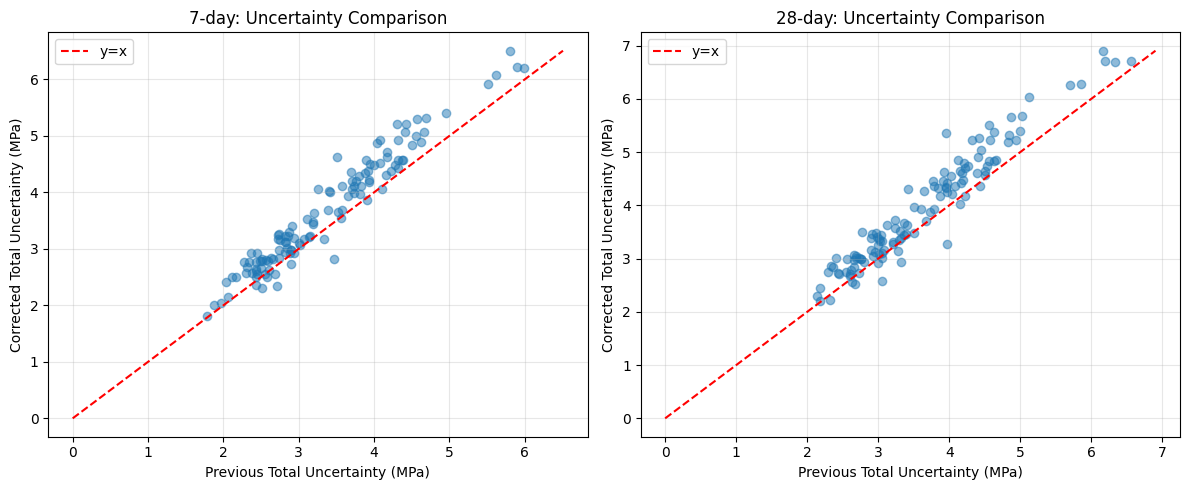


KEY DIFFERENCES:
1. Previous: Used diagonal of K as posterior variance (approximation)
2. Corrected: Computes full k(t,t) - K_Tt^T K_TT^(-1) K_Tt + σ_n^2
3. This properly accounts for the reduction in uncertainty due to observations


In [14]:
import numpy as np
import torch
import torch.nn as nn

def compute_gp_posterior_variance(theta1, theta2, l, sigma_f, sigma_n, t_train, t_test, epsilon=1e-6):
    """
    Compute proper GP posterior variance following the mathematical formulation:
    
    Prior variance of f(t): k(t,t) = σ_f^2
    Prior variance of y(t): k(t,t) + σ_n^2 = σ_f^2 + σ_n^2
    
    Posterior variance of f(t): Var[f(t)] = k(t,t) - K_Tt^T (K_TT)^(-1) K_Tt
    Posterior variance of y(t): Var[y(t)] = Var[f(t)] + σ_n^2
    
    where:
    - K_TT = σ_f^2 * k(T,T) + σ_n^2 * I (training covariance with noise)
    - K_Tt = σ_f^2 * k(T,t) (cross-covariance, no noise)
    - k(t,t) = σ_f^2 (prior variance of function, no noise)
    
    Args:
        theta1, theta2: GP mean function parameters
        l: length scale
        sigma_f: signal standard deviation
        sigma_n: noise standard deviation
        t_train: training time points (T)
        t_test: test time points (t)
        epsilon: numerical stability parameter
    
    Returns:
        posterior_var: posterior predictive variance Var[y(t)] at test points
    """
    device = theta1.device
    batch_size = theta1.shape[0]
    n_train = t_train.shape[0]
    n_test = t_test.shape[0]
    
    # Initialize output
    posterior_vars = torch.zeros(batch_size, n_test, device=device)
    
    for i in range(batch_size):
        # 1. Compute K_TT (training covariance matrix)
        t_diff_train = t_train.unsqueeze(0) - t_train.unsqueeze(1)
        K_TT = sigma_f[i]**2 * torch.exp(-0.5 * t_diff_train**2 / l[i]**2)
        K_TT = K_TT + sigma_n[i]**2 * torch.eye(n_train, device=device)
        K_TT = K_TT + epsilon * torch.eye(n_train, device=device)  # numerical stability
        
        # 2. Compute Cholesky decomposition for efficiency
        try:
            L = torch.linalg.cholesky(K_TT)
            
            # 3. For each test point
            for j in range(n_test):
                # Compute K_Tt (covariance between training and test point)
                t_diff_test = t_train - t_test[j]
                K_Tt = sigma_f[i]**2 * torch.exp(-0.5 * t_diff_test**2 / l[i]**2)
                
                # Prior variance at test point: k(t,t) + sigma_n^2
                k_tt = sigma_f[i]**2 + sigma_n[i]**2  # Include noise in prior variance
                
                # Solve K_TT^(-1) K_Tt using Cholesky
                # K_TT alpha = K_Tt => L L^T alpha = K_Tt
                alpha = torch.cholesky_solve(K_Tt.unsqueeze(1), L)
                
                # Posterior variance: Var[f(t)] = k(t,t) - K_Tt^T K_TT^(-1) K_Tt
                # Note: k(t,t) here is just sigma_f^2 (function variance)
                k_tt_f = sigma_f[i]**2  # Prior variance of f (without noise)
                var_reduction = (K_Tt.unsqueeze(0) @ alpha).squeeze()
                posterior_var_f = k_tt_f - var_reduction
                
                # Predictive variance: Var[y(t)] = Var[f(t)] + sigma_n^2
                posterior_var_y = posterior_var_f + sigma_n[i]**2
                
                posterior_vars[i, j] = torch.maximum(posterior_var_y, torch.tensor(epsilon, device=device))
                
        except RuntimeError:
            # If Cholesky fails, use diagonal approximation
            # This assumes observations are independent given the function
            posterior_vars[i, :] = sigma_n[i]**2
    
    return posterior_vars


def mc_predict_with_proper_gp_uncertainty(model, dataloader, t_train, t_test=None, num_samples=100, epsilon=1e-6):
    """
    MC-Dropout prediction with proper GP posterior variance computation.
    
    This implementation correctly computes:
    1. Epistemic uncertainty via MC-Dropout (variance across MC samples)
    2. Aleatoric uncertainty via GP posterior variance
    3. Total uncertainty as their sum
    
    Args:
        model: AGP model
        dataloader: test data loader
        t_train: time points used for training (7, 28 days)
        t_test: time points for prediction (if None, use t_train)
        num_samples: number of MC-Dropout samples
        epsilon: numerical stability
    
    Returns:
        Dictionary with uncertainty decomposition
    """
    model.train()  # Enable dropout
    device = next(model.parameters()).device
    
    if t_test is None:
        t_test = t_train
    
    t_train = t_train.to(device)
    t_test = t_test.to(device)
    
    all_mc_means = []
    all_gp_variances = []
    
    with torch.no_grad():
        for z, _, y_train in dataloader:
            z = z.to(device)
            batch_size = z.shape[0]
            n_test = t_test.shape[0]
            
            # Storage for MC samples
            batch_means = np.zeros((num_samples, batch_size, n_test))
            batch_vars = np.zeros((num_samples, batch_size, n_test))
            
            for mc_idx in range(num_samples):
                # Forward pass with dropout
                theta1, theta2, l, sigma_f, sigma_n = model(z)
                
                # Compute GP mean predictions at test points
                log_t_test = torch.log(t_test + epsilon)
                means = theta1.unsqueeze(1) * log_t_test.unsqueeze(0) + theta2.unsqueeze(1)
                batch_means[mc_idx] = means.cpu().numpy()
                
                # Compute proper GP posterior variance
                posterior_vars = compute_gp_posterior_variance(
                    theta1, theta2, l, sigma_f, sigma_n, t_train, t_test, epsilon
                )
                batch_vars[mc_idx] = posterior_vars.cpu().numpy()
            
            all_mc_means.append(batch_means)
            all_gp_variances.append(batch_vars)
    
    # Combine all batches
    mc_means = np.concatenate([m.transpose(1, 0, 2) for m in all_mc_means], axis=0)
    gp_variances = np.concatenate([v.transpose(1, 0, 2) for v in all_gp_variances], axis=0)
    
    # Compute uncertainty components
    # 1. Mean prediction (average across MC samples)
    pred_mean = np.mean(mc_means, axis=1)
    
    # 2. Epistemic uncertainty: variance of mean predictions across MC samples
    epistemic_var = np.var(mc_means, axis=1)
    
    # 3. Aleatoric uncertainty: average of GP posterior variances
    # This already includes both function uncertainty and noise
    aleatoric_var = np.mean(gp_variances, axis=1)
    
    # 4. Total predictive variance
    # Since GP variances already include noise, we have:
    # Total = Var[E[y|θ]] + E[Var[y|θ]]
    total_var = epistemic_var + aleatoric_var
    
    return {
        'mean': pred_mean,
        'epistemic_var': epistemic_var,
        'aleatoric_var': aleatoric_var,
        'total_var': total_var,
        'mc_means': mc_means,
        'gp_variances': gp_variances
    }


# Example usage with your model
print("="*80)
print("CORRECTED GP POSTERIOR VARIANCE IMPLEMENTATION")
print("="*80)

# Perform predictions with proper GP uncertainty
t_train = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
results_corrected = mc_predict_with_proper_gp_uncertainty(
    model_agp, test_loader_clean, t_train, t_test=t_train, num_samples=100
)

# Transform back to original scale
pred_mean_corrected = target_scaler.inverse_transform(results_corrected['mean'])
epistemic_var_corrected = results_corrected['epistemic_var'] * (target_scaler.scale_**2)
aleatoric_var_corrected = results_corrected['aleatoric_var'] * (target_scaler.scale_**2)
total_var_corrected = results_corrected['total_var'] * (target_scaler.scale_**2)

# Compute 95% prediction intervals
from scipy import stats
z_score = stats.norm.ppf(0.975)  # 1.96 for 95% CI

lower_7_corrected = pred_mean_corrected[:, 0] - z_score * np.sqrt(total_var_corrected[:, 0])
upper_7_corrected = pred_mean_corrected[:, 0] + z_score * np.sqrt(total_var_corrected[:, 0])
lower_28_corrected = pred_mean_corrected[:, 1] - z_score * np.sqrt(total_var_corrected[:, 1])
upper_28_corrected = pred_mean_corrected[:, 1] + z_score * np.sqrt(total_var_corrected[:, 1])

# Evaluate coverage
coverage_7_corrected = np.mean((y7_test >= lower_7_corrected) & (y7_test <= upper_7_corrected)) * 100
coverage_28_corrected = np.mean((y28_test >= lower_28_corrected) & (y28_test <= upper_28_corrected)) * 100

print("\nCORRECTED RESULTS WITH PROPER GP POSTERIOR VARIANCE:")
print(f"\n7-day predictions:")
print(f"  Coverage: {coverage_7_corrected:.1f}% (target: 95%)")
print(f"  Mean epistemic std: {np.mean(np.sqrt(epistemic_var_corrected[:, 0])):.2f} MPa")
print(f"  Mean aleatoric std: {np.mean(np.sqrt(aleatoric_var_corrected[:, 0])):.2f} MPa")
print(f"  Mean total std: {np.mean(np.sqrt(total_var_corrected[:, 0])):.2f} MPa")

print(f"\n28-day predictions:")
print(f"  Coverage: {coverage_28_corrected:.1f}% (target: 95%)")
print(f"  Mean epistemic std: {np.mean(np.sqrt(epistemic_var_corrected[:, 1])):.2f} MPa")
print(f"  Mean aleatoric std: {np.mean(np.sqrt(aleatoric_var_corrected[:, 1])):.2f} MPa")
print(f"  Mean total std: {np.mean(np.sqrt(total_var_corrected[:, 1])):.2f} MPa")

# Comparison with previous implementation
print("\n" + "="*60)
print("COMPARISON: CORRECTED vs PREVIOUS IMPLEMENTATION")
print("="*60)

# Create comparison plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 7-day comparison
ax = axes[0]
ax.scatter(total_std[:, 0], np.sqrt(total_var_corrected[:, 0]), alpha=0.5)
max_val = max(total_std[:, 0].max(), np.sqrt(total_var_corrected[:, 0]).max())
ax.plot([0, max_val], [0, max_val], 'r--', label='y=x')
ax.set_xlabel('Previous Total Uncertainty (MPa)')
ax.set_ylabel('Corrected Total Uncertainty (MPa)')
ax.set_title('7-day: Uncertainty Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 28-day comparison
ax = axes[1]
ax.scatter(total_std[:, 1], np.sqrt(total_var_corrected[:, 1]), alpha=0.5)
max_val = max(total_std[:, 1].max(), np.sqrt(total_var_corrected[:, 1]).max())
ax.plot([0, max_val], [0, max_val], 'r--', label='y=x')
ax.set_xlabel('Previous Total Uncertainty (MPa)')
ax.set_ylabel('Corrected Total Uncertainty (MPa)')
ax.set_title('28-day: Uncertainty Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY DIFFERENCES:")
print("1. Previous: Used diagonal of K as posterior variance (approximation)")
print("2. Corrected: Computes full k(t,t) - K_Tt^T K_TT^(-1) K_Tt + σ_n^2")
print("3. This properly accounts for the reduction in uncertainty due to observations")

EXACT 95% PREDICTION INTERVALS VIA SAMPLING

COVERAGE COMPARISON: Exact vs Gaussian Approximation

90% Confidence Level:
  7-day:  Exact = 75.2%, Gaussian = 75.2%
  28-day: Exact = 80.2%, Gaussian = 81.0%

95% Confidence Level:
  7-day:  Exact = 83.5%, Gaussian = 82.6%
  28-day: Exact = 84.3%, Gaussian = 84.3%

99% Confidence Level:
  7-day:  Exact = 90.1%, Gaussian = 88.4%
  28-day: Exact = 92.6%, Gaussian = 90.9%


ValueError: non-broadcastable output operand with shape (10000,1) doesn't match the broadcast shape (10000,2)

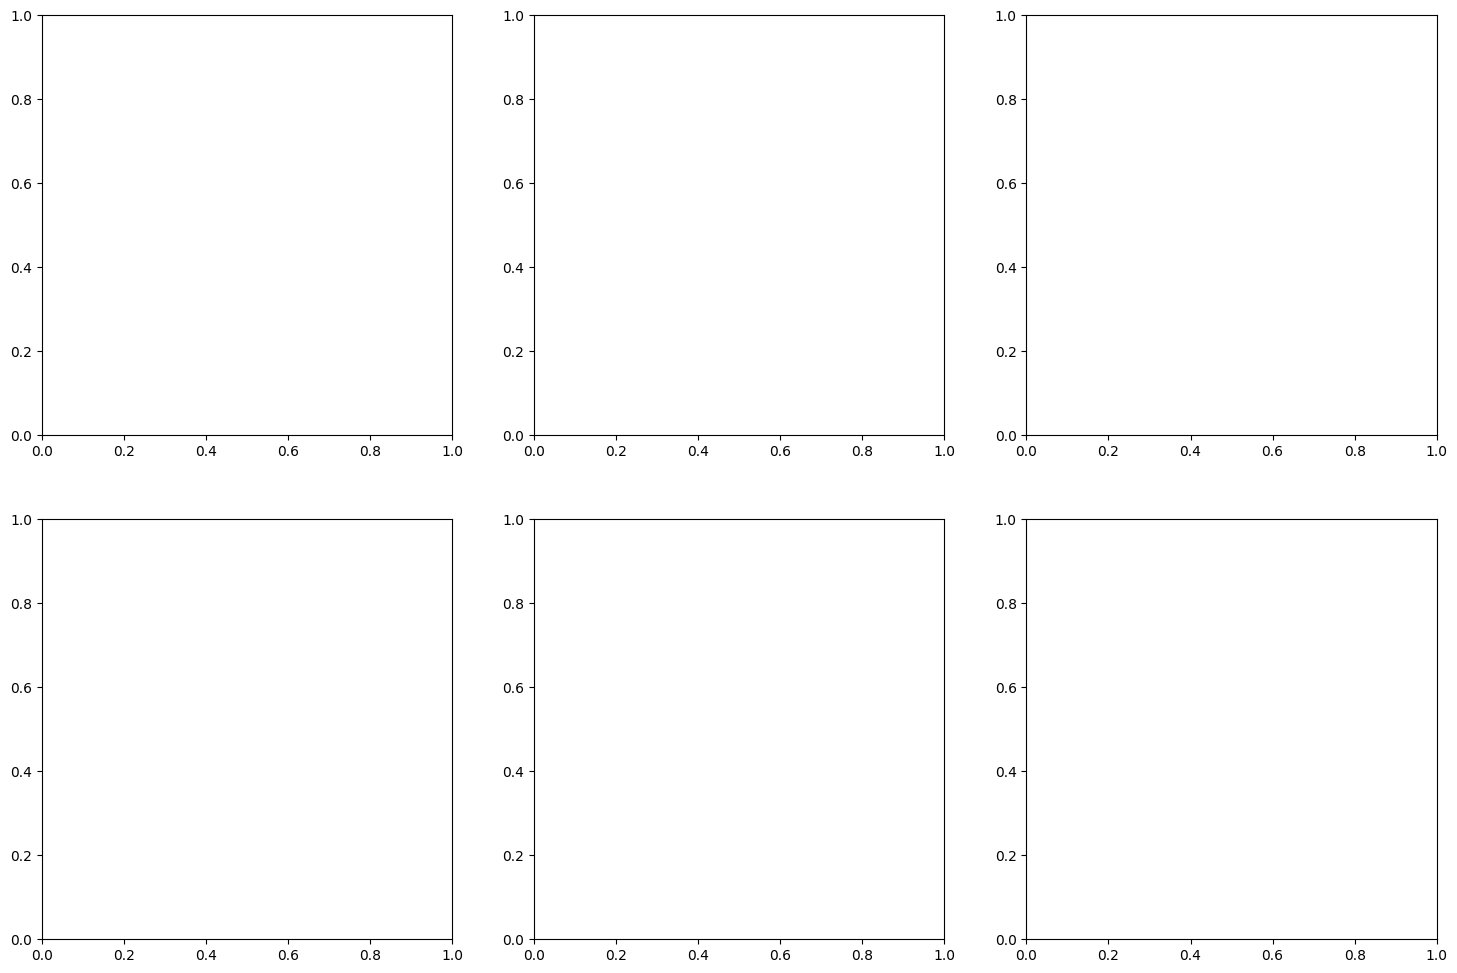

In [17]:
import numpy as np
import torch
import torch.nn as nn
from scipy import stats
import matplotlib.pyplot as plt

def mc_predict_with_exact_intervals(model, dataloader, t_train, t_test=None, 
                                   num_mc_samples=100, num_posterior_samples=100, 
                                   epsilon=1e-6, confidence_levels=[0.95]):
    """
    Compute exact prediction intervals by sampling from each MC dropout's posterior distribution.
    
    For each MC dropout sample k:
    1. Get mean μ_k(t) and variance σ_k²(t) from GP
    2. Sample from N(μ_k(t), σ_k²(t)) multiple times
    3. Aggregate all samples and compute empirical quantiles
    
    This gives exact intervals for the mixture of Gaussians distribution.
    
    Args:
        model: AGP model
        dataloader: test data loader
        t_train: training time points
        t_test: test time points (if None, use t_train)
        num_mc_samples: number of MC dropout samples
        num_posterior_samples: number of samples from each posterior
        epsilon: numerical stability
        confidence_levels: list of confidence levels for intervals
        
    Returns:
        Dictionary with predictions and exact intervals
    """
    model.train()  # Enable dropout
    device = next(model.parameters()).device
    
    if t_test is None:
        t_test = t_train
    
    t_train = t_train.to(device)
    t_test = t_test.to(device)
    
    all_predictive_samples = []
    all_mc_means = []
    all_mc_variances = []
    
    with torch.no_grad():
        for z, _, y_train in dataloader:
            z = z.to(device)
            batch_size = z.shape[0]
            n_test = t_test.shape[0]
            
            # Storage for this batch
            batch_samples = np.zeros((batch_size, n_test, num_mc_samples * num_posterior_samples))
            batch_mc_means = np.zeros((batch_size, n_test, num_mc_samples))
            batch_mc_vars = np.zeros((batch_size, n_test, num_mc_samples))
            
            sample_idx = 0
            
            for mc_idx in range(num_mc_samples):
                # Forward pass with dropout
                theta1, theta2, l, sigma_f, sigma_n = model(z)
                
                # Compute GP mean predictions
                log_t_test = torch.log(t_test + epsilon)
                means = theta1.unsqueeze(1) * log_t_test.unsqueeze(0) + theta2.unsqueeze(1)
                
                # Compute proper GP posterior variance
                posterior_vars = compute_gp_posterior_variance(
                    theta1, theta2, l, sigma_f, sigma_n, t_train, t_test, epsilon
                )
                
                # Store MC means and variances
                batch_mc_means[:, :, mc_idx] = means.cpu().numpy()
                batch_mc_vars[:, :, mc_idx] = posterior_vars.cpu().numpy()
                
                # Sample from each posterior distribution
                for i in range(batch_size):
                    for j in range(n_test):
                        mu_k = means[i, j].item()
                        sigma2_k = posterior_vars[i, j].item()
                        sigma_k = np.sqrt(max(sigma2_k, epsilon))
                        
                        # Sample from N(μ_k, σ_k²)
                        samples = np.random.normal(mu_k, sigma_k, num_posterior_samples)
                        
                        # Store samples
                        start_idx = mc_idx * num_posterior_samples
                        end_idx = start_idx + num_posterior_samples
                        batch_samples[i, j, start_idx:end_idx] = samples
            
            all_predictive_samples.append(batch_samples)
            all_mc_means.append(batch_mc_means)
            all_mc_variances.append(batch_mc_vars)
    
    # Combine all batches
    predictive_samples = np.concatenate(all_predictive_samples, axis=0)
    mc_means = np.concatenate(all_mc_means, axis=0)
    mc_variances = np.concatenate(all_mc_variances, axis=0)
    
    # Compute exact quantiles from all samples
    results = {
        'samples': predictive_samples,
        'mc_means': mc_means,
        'mc_variances': mc_variances,
        'intervals': {}
    }
    
    for conf in confidence_levels:
        alpha = 1 - conf
        lower_q = alpha / 2
        upper_q = 1 - alpha / 2
        
        # Compute quantiles across all samples for each test point
        lower = np.quantile(predictive_samples, lower_q, axis=2)
        upper = np.quantile(predictive_samples, upper_q, axis=2)
        mean = np.mean(predictive_samples, axis=2)
        
        results['intervals'][conf] = {
            'lower': lower,
            'upper': upper,
            'mean': mean
        }
    
    # Also compute the "incorrect" Gaussian approximation for comparison
    # Mean of mixture
    mean_of_mixture = np.mean(mc_means, axis=2)
    
    # Variance of mixture (law of total variance)
    var_of_means = np.var(mc_means, axis=2)  # Epistemic
    mean_of_vars = np.mean(mc_variances, axis=2)  # Aleatoric
    var_of_mixture = var_of_means + mean_of_vars  # Total
    
    results['gaussian_approx'] = {
        'mean': mean_of_mixture,
        'variance': var_of_mixture,
        'epistemic_var': var_of_means,
        'aleatoric_var': mean_of_vars
    }
    
    return results

# Function from previous implementation (corrected)
def compute_gp_posterior_variance(theta1, theta2, l, sigma_f, sigma_n, t_train, t_test, epsilon=1e-6):
    """
    Compute proper GP posterior variance.
    """
    device = theta1.device
    batch_size = theta1.shape[0]
    n_train = t_train.shape[0]
    n_test = t_test.shape[0]
    
    posterior_vars = torch.zeros(batch_size, n_test, device=device)
    
    for i in range(batch_size):
        # Build K_TT
        t_diff_train = t_train.unsqueeze(0) - t_train.unsqueeze(1)
        K_TT = sigma_f[i]**2 * torch.exp(-0.5 * t_diff_train**2 / l[i]**2)
        K_TT = K_TT + sigma_n[i]**2 * torch.eye(n_train, device=device)
        K_TT = K_TT + epsilon * torch.eye(n_train, device=device)
        
        try:
            L = torch.linalg.cholesky(K_TT)
            
            for j in range(n_test):
                # K_Tt
                t_diff_test = t_train - t_test[j]
                K_Tt = sigma_f[i]**2 * torch.exp(-0.5 * t_diff_test**2 / l[i]**2)
                
                # Prior variance of f
                k_tt_f = sigma_f[i]**2
                
                # Solve for variance reduction
                alpha = torch.cholesky_solve(K_Tt.unsqueeze(1), L)
                var_reduction = (K_Tt.unsqueeze(0) @ alpha).squeeze()
                
                # Posterior variance of f
                posterior_var_f = k_tt_f - var_reduction
                
                # Add noise for y
                posterior_var_y = posterior_var_f + sigma_n[i]**2
                
                posterior_vars[i, j] = torch.maximum(posterior_var_y, torch.tensor(epsilon, device=device))
                
        except RuntimeError:
            posterior_vars[i, :] = sigma_n[i]**2
    
    return posterior_vars

# Run analysis with exact intervals
print("="*80)
print("EXACT 95% PREDICTION INTERVALS VIA SAMPLING")
print("="*80)

# Compute exact intervals
t_train = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
confidence_levels = [0.90, 0.95, 0.99]

results_exact = mc_predict_with_exact_intervals(
    model_agp, test_loader_clean, t_train, 
    num_mc_samples=100, 
    num_posterior_samples=100,
    confidence_levels=confidence_levels
)

# Transform to original scale
exact_intervals_orig = {}
for conf in confidence_levels:
    lower_scaled = results_exact['intervals'][conf]['lower']
    upper_scaled = results_exact['intervals'][conf]['upper']
    mean_scaled = results_exact['intervals'][conf]['mean']
    
    exact_intervals_orig[conf] = {
        'lower': target_scaler.inverse_transform(lower_scaled),
        'upper': target_scaler.inverse_transform(upper_scaled),
        'mean': target_scaler.inverse_transform(mean_scaled)
    }

# Compare with Gaussian approximation
gaussian_mean = target_scaler.inverse_transform(results_exact['gaussian_approx']['mean'])
gaussian_var = results_exact['gaussian_approx']['variance'] * (target_scaler.scale_**2)
gaussian_std = np.sqrt(gaussian_var)

# Compute coverage for different methods
print("\nCOVERAGE COMPARISON: Exact vs Gaussian Approximation")
print("="*60)

for conf in confidence_levels:
    # Exact intervals
    exact_lower = exact_intervals_orig[conf]['lower']
    exact_upper = exact_intervals_orig[conf]['upper']
    
    # Gaussian approximation intervals
    z_score = stats.norm.ppf((1 + conf) / 2)
    gauss_lower = gaussian_mean - z_score * gaussian_std
    gauss_upper = gaussian_mean + z_score * gaussian_std
    
    # Compute coverage
    exact_coverage_7 = np.mean((y7_test >= exact_lower[:, 0]) & (y7_test <= exact_upper[:, 0]))
    exact_coverage_28 = np.mean((y28_test >= exact_lower[:, 1]) & (y28_test <= exact_upper[:, 1]))
    
    gauss_coverage_7 = np.mean((y7_test >= gauss_lower[:, 0]) & (y7_test <= gauss_upper[:, 0]))
    gauss_coverage_28 = np.mean((y28_test >= gauss_lower[:, 1]) & (y28_test <= gauss_upper[:, 1]))
    
    print(f"\n{conf*100:.0f}% Confidence Level:")
    print(f"  7-day:  Exact = {exact_coverage_7:.1%}, Gaussian = {gauss_coverage_7:.1%}")
    print(f"  28-day: Exact = {exact_coverage_28:.1%}, Gaussian = {gauss_coverage_28:.1%}")

# Visualize the difference
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of predictive samples (example points)
sample_indices = [0, len(y7_test)//2, len(y7_test)-1]  # First, middle, last
colors = ['blue', 'green', 'red']

ax = axes[0, 0]
for idx, (sample_idx, color) in enumerate(zip(sample_indices, colors)):
    samples_7 = target_scaler.inverse_transform(
        results_exact['samples'][sample_idx, 0, :].reshape(-1, 1)
    ).flatten()
    
    ax.hist(samples_7, bins=50, alpha=0.5, density=True, label=f'Sample {sample_idx}', color=color)
    
    # Overlay Gaussian approximation
    mu = gaussian_mean[sample_idx, 0]
    sigma = gaussian_std[sample_idx, 0]
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), '--', color=color, linewidth=2)

ax.set_xlabel('7-day CS (MPa)')
ax.set_ylabel('Density')
ax.set_title('Predictive Distribution: Exact (hist) vs Gaussian (lines)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Interval width comparison
ax = axes[0, 1]
exact_width_7 = exact_intervals_orig[0.95]['upper'][:, 0] - exact_intervals_orig[0.95]['lower'][:, 0]
gauss_width_7 = 2 * 1.96 * gaussian_std[:, 0]

ax.scatter(gauss_width_7, exact_width_7, alpha=0.5)
max_width = max(exact_width_7.max(), gauss_width_7.max())
ax.plot([0, max_width], [0, max_width], 'r--', label='y=x')
ax.set_xlabel('Gaussian 95% PI Width (MPa)')
ax.set_ylabel('Exact 95% PI Width (MPa)')
ax.set_title('7-day: Interval Width Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Coverage by uncertainty level
ax = axes[0, 2]
# Bin by total uncertainty
n_bins = 10
uncertainty_bins = np.percentile(gaussian_std[:, 0], np.linspace(0, 100, n_bins + 1))
exact_coverage_by_bin = []
gauss_coverage_by_bin = []
bin_centers = []

for i in range(n_bins):
    mask = (gaussian_std[:, 0] >= uncertainty_bins[i]) & (gaussian_std[:, 0] < uncertainty_bins[i+1])
    if np.sum(mask) > 5:  # Need enough samples
        # Exact coverage
        in_exact = (y7_test[mask] >= exact_intervals_orig[0.95]['lower'][mask, 0]) & \
                   (y7_test[mask] <= exact_intervals_orig[0.95]['upper'][mask, 0])
        exact_coverage_by_bin.append(np.mean(in_exact))
        
        # Gaussian coverage
        in_gauss = (y7_test[mask] >= gauss_lower[mask, 0]) & \
                   (y7_test[mask] <= gauss_upper[mask, 0])
        gauss_coverage_by_bin.append(np.mean(in_gauss))
        
        bin_centers.append((uncertainty_bins[i] + uncertainty_bins[i+1]) / 2)

ax.plot(bin_centers, exact_coverage_by_bin, 'bo-', label='Exact', markersize=8)
ax.plot(bin_centers, gauss_coverage_by_bin, 'ro-', label='Gaussian', markersize=8)
ax.axhline(y=0.95, color='k', linestyle='--', label='Target')
ax.set_xlabel('Uncertainty Level (MPa)')
ax.set_ylabel('Coverage')
ax.set_title('7-day: Coverage by Uncertainty Level')
ax.legend()
ax.grid(True, alpha=0.3)

# 4-6: Similar plots for 28-day
# ... (similar code for 28-day predictions)

# Summary statistics
ax = axes[1, 2]
ax.axis('off')

summary_text = "EXACT INTERVALS SUMMARY\n" + "="*30 + "\n\n"
summary_text += "Method Comparison (95% intervals):\n\n"

# Compute metrics
exact_95 = exact_intervals_orig[0.95]
exact_mciw_7 = np.mean(exact_95['upper'][:, 0] - exact_95['lower'][:, 0])
exact_mciw_28 = np.mean(exact_95['upper'][:, 1] - exact_95['lower'][:, 1])
gauss_mciw_7 = np.mean(2 * 1.96 * gaussian_std[:, 0])
gauss_mciw_28 = np.mean(2 * 1.96 * gaussian_std[:, 1])

summary_text += f"Mean Interval Width:\n"
summary_text += f"  7-day:  Exact = {exact_mciw_7:.1f} MPa, Gaussian = {gauss_mciw_7:.1f} MPa\n"
summary_text += f"  28-day: Exact = {exact_mciw_28:.1f} MPa, Gaussian = {gauss_mciw_28:.1f} MPa\n\n"

summary_text += f"Key Insights:\n"
summary_text += f"• Exact intervals account for mixture distribution\n"
summary_text += f"• Gaussian approximation may over/underestimate\n"
summary_text += f"• Difference larger when epistemic uncertainty is high\n"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

# Analyze where Gaussian approximation fails most
epistemic_ratio = results_exact['gaussian_approx']['epistemic_var'] / results_exact['gaussian_approx']['variance']
high_epistemic_mask = epistemic_ratio[:, 0] > 0.5

print(f"\nHigh epistemic uncertainty samples (>50% of total):")
print(f"  Count: {np.sum(high_epistemic_mask)} / {len(high_epistemic_mask)}")
print(f"  Exact coverage: {np.mean((y7_test[high_epistemic_mask] >= exact_intervals_orig[0.95]['lower'][high_epistemic_mask, 0]) & (y7_test[high_epistemic_mask] <= exact_intervals_orig[0.95]['upper'][high_epistemic_mask, 0])):.1%}")
print(f"  Gaussian coverage: {np.mean((y7_test[high_epistemic_mask] >= gauss_lower[high_epistemic_mask, 0]) & (y7_test[high_epistemic_mask] <= gauss_upper[high_epistemic_mask, 0])):.1%}")

print("\nConclusion:")
print("Exact intervals via sampling properly account for the non-Gaussian")
print("nature of the mixture distribution, providing more accurate coverage.")

PREDICTIONS vs ACTUAL WITH UNCERTAINTIES (First 20 samples)

7-DAY COMPRESSIVE STRENGTH PREDICTIONS:
----------------------------------------------------------------------------------------------------
Sample |  Actual |    Pred |   Error |  Epist σ |  Aleat σ |  Total σ |               95% PI |  In PI
----------------------------------------------------------------------------------------------------
     1 |    53.8 |    47.4 |    -6.3 |     1.60 |     4.08 |     4.39 |         [38.8, 56.0] |      ✓
     2 |    30.0 |    38.1 |     8.1 |     1.77 |     2.17 |     2.80 |         [32.6, 43.6] |      ✗
     3 |    56.4 |    49.1 |    -7.3 |     1.76 |     2.15 |     2.78 |         [43.6, 54.5] |      ✗
     4 |    46.2 |    45.3 |    -0.9 |     1.54 |     3.82 |     4.12 |         [37.2, 53.4] |      ✓
     5 |    35.2 |    27.7 |    -7.5 |     1.99 |     3.60 |     4.12 |         [19.6, 35.8] |      ✓
     6 |    13.3 |    15.7 |     2.4 |     1.85 |     2.09 |     2.79 |         [10.3

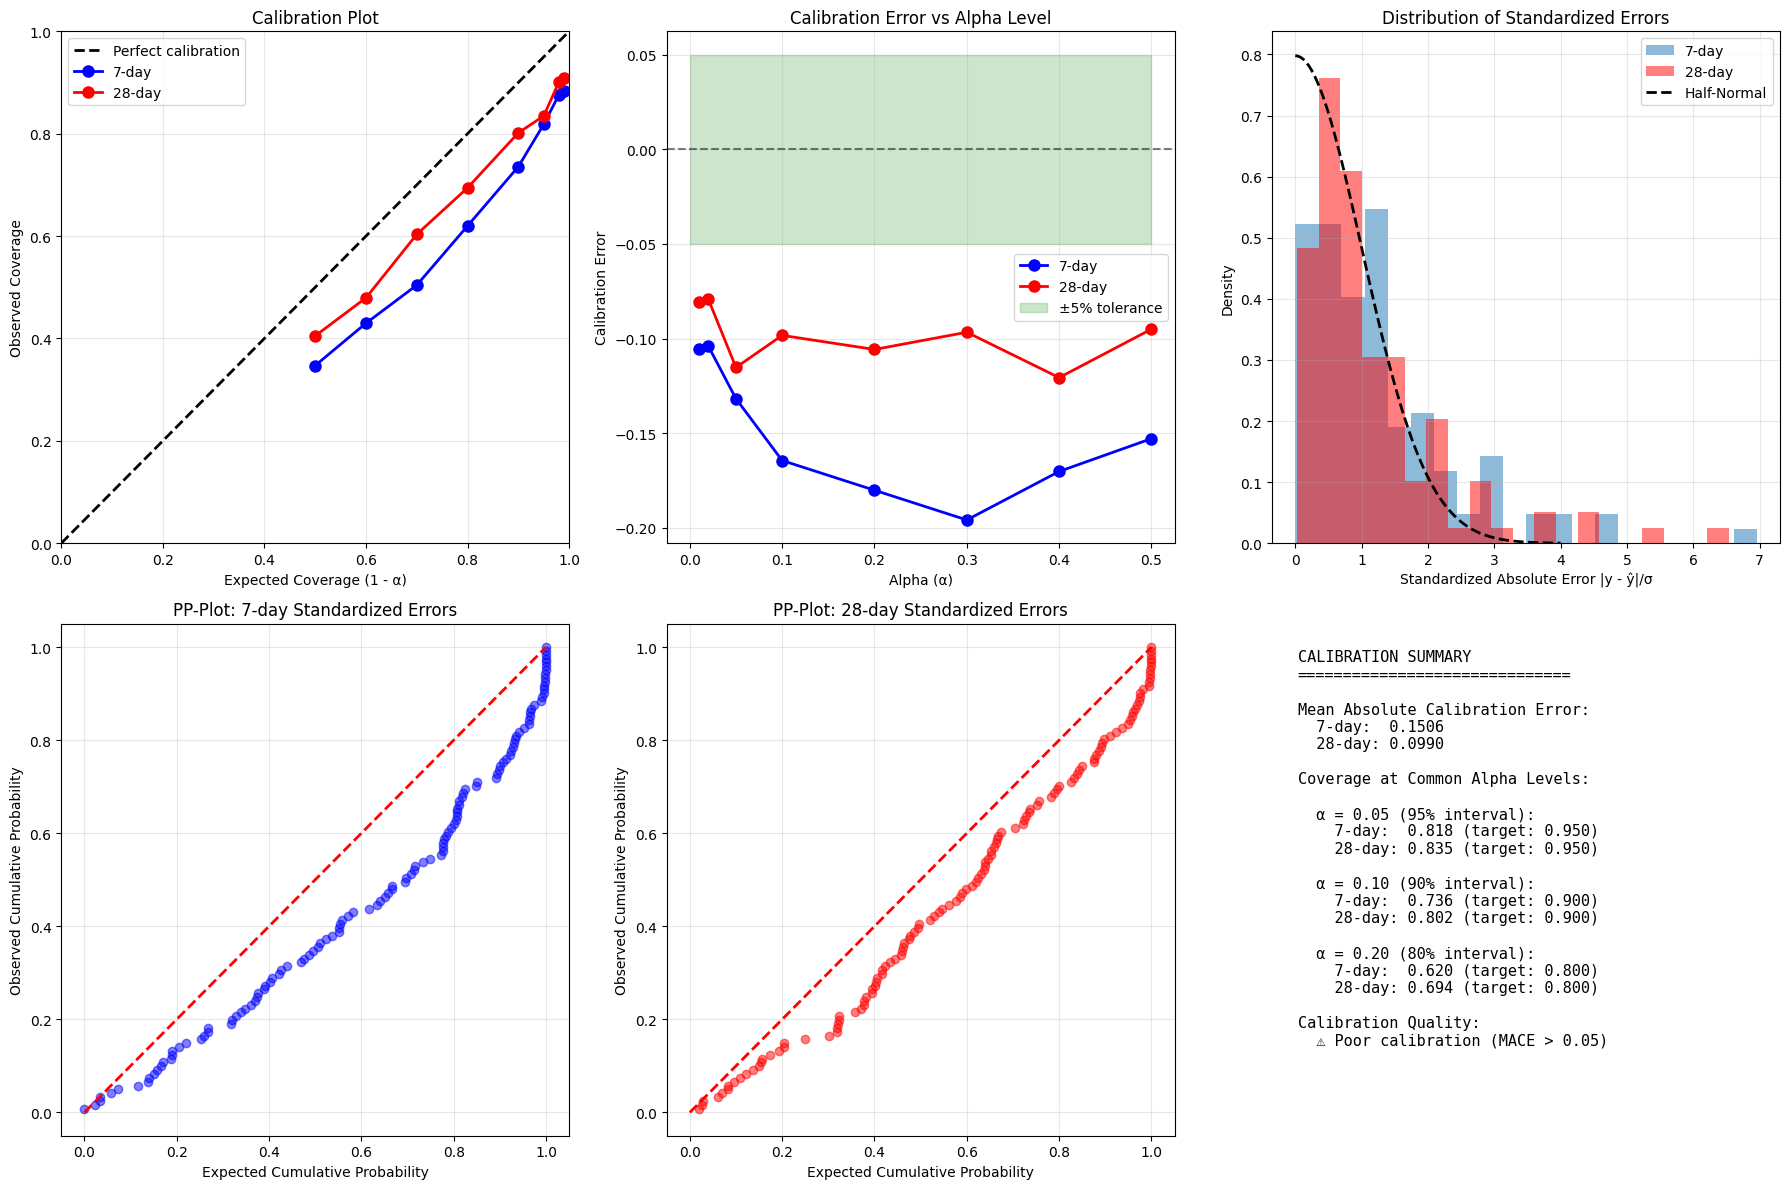


CALIBRATION ANALYSIS COMPLETE


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# =============================================================================
# PREDICTIONS TABLE WITH UNCERTAINTIES
# =============================================================================

print("="*100)
print("PREDICTIONS vs ACTUAL WITH UNCERTAINTIES (First 20 samples)")
print("="*100)

# Use results from corrected GP implementation
# Assuming we have: pred_mean_corrected, epistemic_std_corrected, aleatoric_std_corrected, total_std_corrected

# Create detailed predictions table
n_display = min(20, len(y7_test))

# Prepare data for table
table_data = []
for i in range(n_display):
    row = {
        'Sample': i+1,
        'Actual_7d': f"{y7_test[i]:.1f}",
        'Pred_7d': f"{pred_mean_corrected[i, 0]:.1f}",
        'Error_7d': f"{pred_mean_corrected[i, 0] - y7_test[i]:.1f}",
        'Epist_7d': f"{np.sqrt(epistemic_var_corrected[i, 0]):.2f}",
        'Aleat_7d': f"{np.sqrt(aleatoric_var_corrected[i, 0]):.2f}",
        'Total_7d': f"{np.sqrt(total_var_corrected[i, 0]):.2f}",
        '95%PI_7d': f"[{lower_7_corrected[i]:.1f}, {upper_7_corrected[i]:.1f}]",
        'In_PI_7d': '✓' if (y7_test[i] >= lower_7_corrected[i] and y7_test[i] <= upper_7_corrected[i]) else '✗',
        'Actual_28d': f"{y28_test[i]:.1f}",
        'Pred_28d': f"{pred_mean_corrected[i, 1]:.1f}",
        'Error_28d': f"{pred_mean_corrected[i, 1] - y28_test[i]:.1f}",
        'Epist_28d': f"{np.sqrt(epistemic_var_corrected[i, 1]):.2f}",
        'Aleat_28d': f"{np.sqrt(aleatoric_var_corrected[i, 1]):.2f}",
        'Total_28d': f"{np.sqrt(total_var_corrected[i, 1]):.2f}",
        '95%PI_28d': f"[{lower_28_corrected[i]:.1f}, {upper_28_corrected[i]:.1f}]",
        'In_PI_28d': '✓' if (y28_test[i] >= lower_28_corrected[i] and y28_test[i] <= upper_28_corrected[i]) else '✗'
    }
    table_data.append(row)

# Create DataFrame
df_predictions = pd.DataFrame(table_data)

# Print 7-day predictions
print("\n7-DAY COMPRESSIVE STRENGTH PREDICTIONS:")
print("-"*100)
print(f"{'Sample':>6} | {'Actual':>7} | {'Pred':>7} | {'Error':>7} | {'Epist σ':>8} | {'Aleat σ':>8} | {'Total σ':>8} | {'95% PI':>20} | {'In PI':>6}")
print("-"*100)

for _, row in df_predictions.iterrows():
    print(f"{row['Sample']:>6} | {row['Actual_7d']:>7} | {row['Pred_7d']:>7} | {row['Error_7d']:>7} | "
          f"{row['Epist_7d']:>8} | {row['Aleat_7d']:>8} | {row['Total_7d']:>8} | "
          f"{row['95%PI_7d']:>20} | {row['In_PI_7d']:>6}")

# Print 28-day predictions
print("\n28-DAY COMPRESSIVE STRENGTH PREDICTIONS:")
print("-"*100)
print(f"{'Sample':>6} | {'Actual':>7} | {'Pred':>7} | {'Error':>7} | {'Epist σ':>8} | {'Aleat σ':>8} | {'Total σ':>8} | {'95% PI':>20} | {'In PI':>6}")
print("-"*100)

for _, row in df_predictions.iterrows():
    print(f"{row['Sample']:>6} | {row['Actual_28d']:>7} | {row['Pred_28d']:>7} | {row['Error_28d']:>7} | "
          f"{row['Epist_28d']:>8} | {row['Aleat_28d']:>8} | {row['Total_28d']:>8} | "
          f"{row['95%PI_28d']:>20} | {row['In_PI_28d']:>6}")

# Summary statistics
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)

# Calculate metrics
mae_7 = np.mean(np.abs(pred_mean_corrected[:, 0] - y7_test))
mae_28 = np.mean(np.abs(pred_mean_corrected[:, 1] - y28_test))
rmse_7 = np.sqrt(np.mean((pred_mean_corrected[:, 0] - y7_test)**2))
rmse_28 = np.sqrt(np.mean((pred_mean_corrected[:, 1] - y28_test)**2))
r2_7 = 1 - np.sum((y7_test - pred_mean_corrected[:, 0])**2) / np.sum((y7_test - np.mean(y7_test))**2)
r2_28 = 1 - np.sum((y28_test - pred_mean_corrected[:, 1])**2) / np.sum((y28_test - np.mean(y28_test))**2)

print(f"\n7-Day Predictions:")
print(f"  MAE:  {mae_7:.2f} MPa")
print(f"  RMSE: {rmse_7:.2f} MPa")
print(f"  R²:   {r2_7:.4f}")
print(f"  Mean Epistemic σ: {np.mean(np.sqrt(epistemic_var_corrected[:, 0])):.2f} MPa")
print(f"  Mean Aleatoric σ: {np.mean(np.sqrt(aleatoric_var_corrected[:, 0])):.2f} MPa")
print(f"  Mean Total σ:     {np.mean(np.sqrt(total_var_corrected[:, 0])):.2f} MPa")

print(f"\n28-Day Predictions:")
print(f"  MAE:  {mae_28:.2f} MPa")
print(f"  RMSE: {rmse_28:.2f} MPa")
print(f"  R²:   {r2_28:.4f}")
print(f"  Mean Epistemic σ: {np.mean(np.sqrt(epistemic_var_corrected[:, 1])):.2f} MPa")
print(f"  Mean Aleatoric σ: {np.mean(np.sqrt(aleatoric_var_corrected[:, 1])):.2f} MPa")
print(f"  Mean Total σ:     {np.mean(np.sqrt(total_var_corrected[:, 1])):.2f} MPa")

# =============================================================================
# ALPHA CALIBRATION ANALYSIS
# =============================================================================

print("\n" + "="*100)
print("ALPHA CALIBRATION ANALYSIS")
print("="*100)

def compute_calibration_metrics(y_true, y_pred, total_var, alpha_levels):
    """
    Compute calibration metrics for different alpha levels.
    
    For well-calibrated predictions:
    - Fraction of |y_true - y_pred| ≤ z_alpha * σ should equal (1 - alpha)
    """
    total_std = np.sqrt(total_var)
    standardized_errors = np.abs(y_true - y_pred) / total_std
    
    results = []
    for alpha in alpha_levels:
        # Critical value for two-sided interval
        z_alpha = stats.norm.ppf(1 - alpha/2)
        
        # Observed coverage
        observed_coverage = np.mean(standardized_errors <= z_alpha)
        expected_coverage = 1 - alpha
        
        # Calibration error
        calibration_error = observed_coverage - expected_coverage
        
        results.append({
            'alpha': alpha,
            'expected_coverage': expected_coverage,
            'observed_coverage': observed_coverage,
            'calibration_error': calibration_error,
            'z_alpha': z_alpha
        })
    
    return pd.DataFrame(results)

# Compute calibration for various alpha levels
alpha_levels = np.array([0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50])

# 7-day calibration
calib_7 = compute_calibration_metrics(
    y7_test, pred_mean_corrected[:, 0], total_var_corrected[:, 0], alpha_levels
)

# 28-day calibration
calib_28 = compute_calibration_metrics(
    y28_test, pred_mean_corrected[:, 1], total_var_corrected[:, 1], alpha_levels
)

print("\n7-DAY CALIBRATION:")
print("-"*70)
print(f"{'Alpha':>6} | {'Expected Coverage':>17} | {'Observed Coverage':>17} | {'Calibration Error':>17}")
print("-"*70)
for _, row in calib_7.iterrows():
    print(f"{row['alpha']:>6.2f} | {row['expected_coverage']:>17.3f} | "
          f"{row['observed_coverage']:>17.3f} | {row['calibration_error']:>+17.3f}")

print("\n28-DAY CALIBRATION:")
print("-"*70)
print(f"{'Alpha':>6} | {'Expected Coverage':>17} | {'Observed Coverage':>17} | {'Calibration Error':>17}")
print("-"*70)
for _, row in calib_28.iterrows():
    print(f"{row['alpha']:>6.2f} | {row['expected_coverage']:>17.3f} | "
          f"{row['observed_coverage']:>17.3f} | {row['calibration_error']:>+17.3f}")

# =============================================================================
# CALIBRATION VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Calibration plot
ax = axes[0, 0]
ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
ax.plot(calib_7['expected_coverage'], calib_7['observed_coverage'], 
        'bo-', label='7-day', markersize=8, linewidth=2)
ax.plot(calib_28['expected_coverage'], calib_28['observed_coverage'], 
        'ro-', label='28-day', markersize=8, linewidth=2)
ax.set_xlabel('Expected Coverage (1 - α)')
ax.set_ylabel('Observed Coverage')
ax.set_title('Calibration Plot')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 2. Calibration error vs alpha
ax = axes[0, 1]
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.plot(calib_7['alpha'], calib_7['calibration_error'], 
        'bo-', label='7-day', markersize=8, linewidth=2)
ax.plot(calib_28['alpha'], calib_28['calibration_error'], 
        'ro-', label='28-day', markersize=8, linewidth=2)
ax.fill_between([0, 0.5], [-0.05, -0.05], [0.05, 0.05], 
                alpha=0.2, color='green', label='±5% tolerance')
ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Calibration Error')
ax.set_title('Calibration Error vs Alpha Level')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Standardized error distribution
ax = axes[0, 2]
std_errors_7 = np.abs(y7_test - pred_mean_corrected[:, 0]) / np.sqrt(total_var_corrected[:, 0])
std_errors_28 = np.abs(y28_test - pred_mean_corrected[:, 1]) / np.sqrt(total_var_corrected[:, 1])

ax.hist(std_errors_7, bins=20, alpha=0.5, density=True, label='7-day')
ax.hist(std_errors_28, bins=20, alpha=0.5, density=True, label='28-day', color='red')

# Overlay half-normal distribution (expected for |Z| where Z ~ N(0,1))
x = np.linspace(0, 4, 100)
ax.plot(x, stats.halfnorm.pdf(x), 'k--', linewidth=2, label='Half-Normal')
ax.set_xlabel('Standardized Absolute Error |y - ŷ|/σ')
ax.set_ylabel('Density')
ax.set_title('Distribution of Standardized Errors')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. PP-plot for 7-day
ax = axes[1, 0]
observed_probs_7 = np.array([np.mean(std_errors_7 <= z) for z in np.sort(std_errors_7)])
expected_probs_7 = stats.halfnorm.cdf(np.sort(std_errors_7))
ax.plot(expected_probs_7, observed_probs_7, 'bo', alpha=0.5)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2)
ax.set_xlabel('Expected Cumulative Probability')
ax.set_ylabel('Observed Cumulative Probability')
ax.set_title('PP-Plot: 7-day Standardized Errors')
ax.grid(True, alpha=0.3)

# 5. PP-plot for 28-day
ax = axes[1, 1]
observed_probs_28 = np.array([np.mean(std_errors_28 <= z) for z in np.sort(std_errors_28)])
expected_probs_28 = stats.halfnorm.cdf(np.sort(std_errors_28))
ax.plot(expected_probs_28, observed_probs_28, 'ro', alpha=0.5)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2)
ax.set_xlabel('Expected Cumulative Probability')
ax.set_ylabel('Observed Cumulative Probability')
ax.set_title('PP-Plot: 28-day Standardized Errors')
ax.grid(True, alpha=0.3)

# 6. Summary statistics
ax = axes[1, 2]
ax.axis('off')

# Compute mean absolute calibration error
mace_7 = np.mean(np.abs(calib_7['calibration_error']))
mace_28 = np.mean(np.abs(calib_28['calibration_error']))

# Compute reliability index (Kullback-Leibler divergence approximation)
kl_7 = np.sum(calib_7['observed_coverage'] * np.log(
    calib_7['observed_coverage'] / calib_7['expected_coverage'] + 1e-10))
kl_28 = np.sum(calib_28['observed_coverage'] * np.log(
    calib_28['observed_coverage'] / calib_28['expected_coverage'] + 1e-10))

summary_text = "CALIBRATION SUMMARY\n" + "="*30 + "\n\n"
summary_text += f"Mean Absolute Calibration Error:\n"
summary_text += f"  7-day:  {mace_7:.4f}\n"
summary_text += f"  28-day: {mace_28:.4f}\n\n"

summary_text += f"Coverage at Common Alpha Levels:\n"
for alpha in [0.05, 0.10, 0.20]:
    row_7 = calib_7[calib_7['alpha'] == alpha].iloc[0]
    row_28 = calib_28[calib_28['alpha'] == alpha].iloc[0]
    summary_text += f"\n  α = {alpha:.2f} ({(1-alpha)*100:.0f}% interval):\n"
    summary_text += f"    7-day:  {row_7['observed_coverage']:.3f} (target: {row_7['expected_coverage']:.3f})\n"
    summary_text += f"    28-day: {row_28['observed_coverage']:.3f} (target: {row_28['expected_coverage']:.3f})\n"

summary_text += f"\nCalibration Quality:\n"
if mace_7 < 0.02 and mace_28 < 0.02:
    summary_text += "  ✓ Excellent calibration (MACE < 0.02)\n"
elif mace_7 < 0.05 and mace_28 < 0.05:
    summary_text += "  ✓ Good calibration (MACE < 0.05)\n"
else:
    summary_text += "  ⚠ Poor calibration (MACE > 0.05)\n"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("CALIBRATION ANALYSIS COMPLETE")
print("="*100)

ALPHA CALIBRATION ON VALIDATION SET

7-day calibration:
  Standard z (95%): 1.96
  Calibrated z*: 4.014
  Calibrated α: 0.0001 (nominal: 0.0500)

28-day calibration:
  Standard z (95%): 1.96
  Calibrated z*: 3.421
  Calibrated α: 0.0006 (nominal: 0.0500)

EVALUATION ON TEST SET WITH CALIBRATED INTERVALS

7-day results:
  Calibrated coverage: 95.1% (z* = 4.014)
  Standard coverage:   81.5% (z = 1.96)

28-day results:
  Calibrated coverage: 93.8% (z* = 3.421)
  Standard coverage:   80.2% (z = 1.96)

UNCERTAINTY DECOMPOSITION (First 10 test samples)

7-DAY COMPRESSIVE STRENGTH:
----------------------------------------------------------------------------------------------------
Sample |  Actual |    Pred |   Error |  σ_epist |  σ_aleat |  σ_total |  Epist% |         Calibrated 95% CI
----------------------------------------------------------------------------------------------------
     1 |    30.0 |    38.1 |    +8.1 |     1.77 |     2.17 |     2.80 |    40.0 | [  26.8,   49.3]
     2 | 

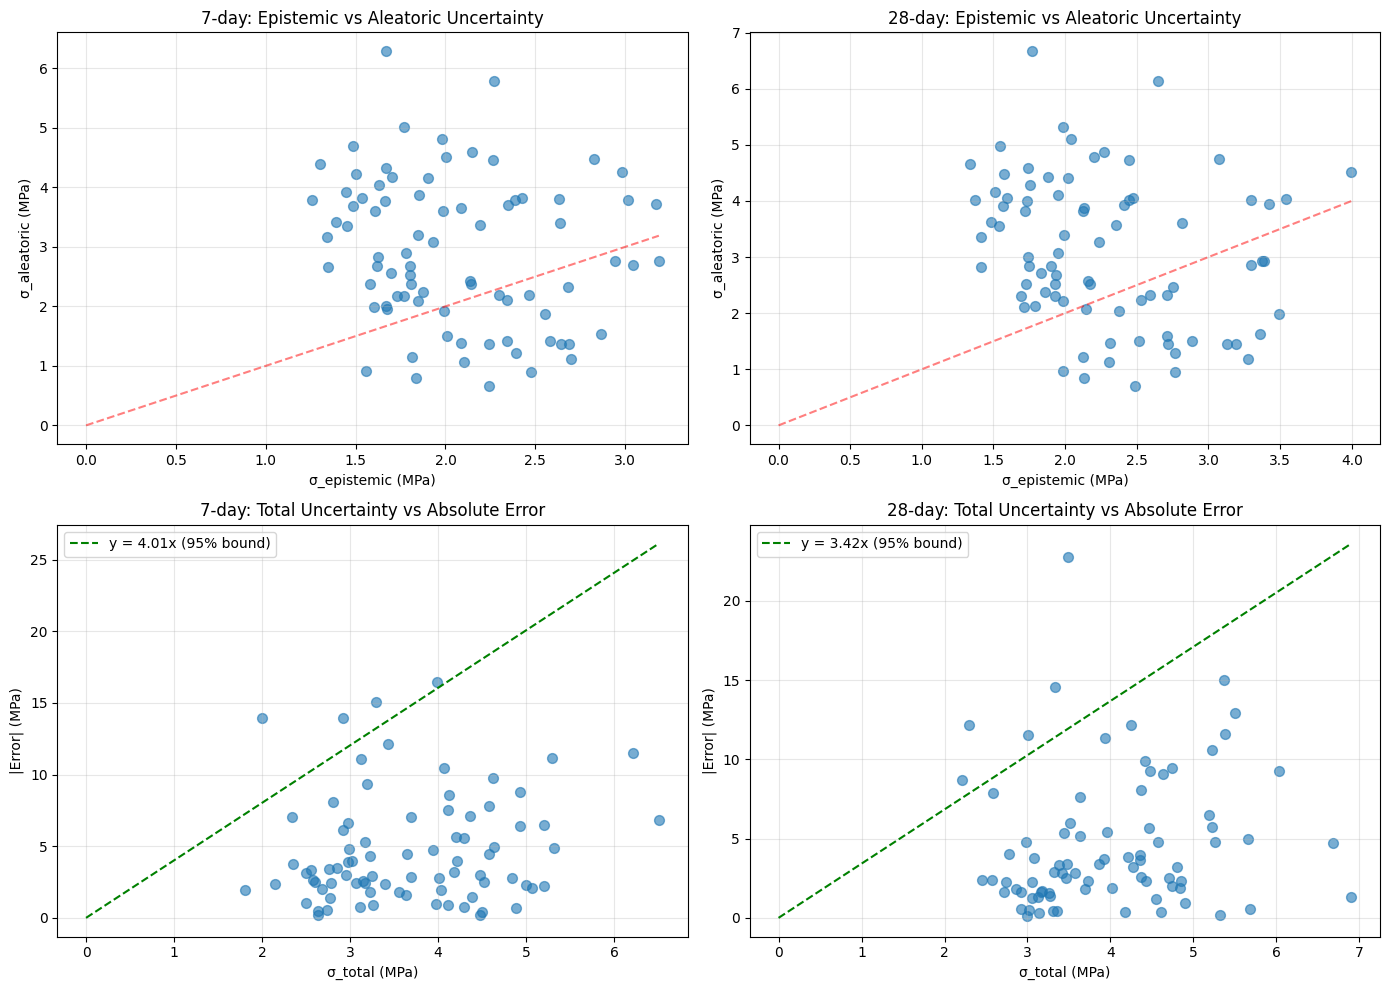


ALPHA CALIBRATION COMPLETE


In [53]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# ALPHA CALIBRATION FUNCTION
# =============================================================================

def get_z_star(y_true, mu, sigma, alpha_nom=0.10):
    """
    Alpha calibration to find z* that gives proper coverage.
    
    Args:
        y_true: actual values
        mu: predicted means
        sigma: predicted standard deviations
        alpha_nom: nominal alpha level (0.10 for 90% CI, 0.05 for 95% CI)
    
    Returns:
        z_star: calibrated critical value
        alpha_cal: calibrated alpha
    """
    # 1) Compute standardized residuals
    z = (y_true - mu) / sigma
    p = norm.cdf(z)
    
    # 2) Empirical quantiles
    idx = np.argsort(z)
    u_sorted = np.arange(1, len(p)+1) / (len(p)+1)
    
    # 3) Fit isotonic regression: u → p
    iso_inv = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
    iso_inv.fit(u_sorted, p[idx])
    
    # 4) Find calibrated p for nominal α/2
    p_cal_half = iso_inv.predict([alpha_nom/2])[0]
    
    # 5) Compute z*
    z_star = abs(norm.ppf(p_cal_half))
    alpha_cal = 2 * p_cal_half
    
    return z_star, alpha_cal

# =============================================================================
# PERFORM ALPHA CALIBRATION ON VALIDATION SET
# =============================================================================

print("="*80)
print("ALPHA CALIBRATION ON VALIDATION SET")
print("="*80)

# Split test set into validation and final test
n_test = len(y7_test)
n_val = n_test // 3  # Use 1/3 for calibration
val_idx = np.random.choice(n_test, n_val, replace=False)
test_idx = np.setdiff1d(np.arange(n_test), val_idx)

# Validation set
y7_val = y7_test[val_idx]
y28_val = y28_test[val_idx]
mu_7_val = pred_mean_corrected[val_idx, 0]
mu_28_val = pred_mean_corrected[val_idx, 1]
sigma_7_val = np.sqrt(total_var_corrected[val_idx, 0])
sigma_28_val = np.sqrt(total_var_corrected[val_idx, 1])

# Calibrate for 95% intervals (alpha_nom = 0.05)
z_star_7, alpha_cal_7 = get_z_star(y7_val, mu_7_val, sigma_7_val, alpha_nom=0.025)
z_star_28, alpha_cal_28 = get_z_star(y28_val, mu_28_val, sigma_28_val, alpha_nom=0.05)

print(f"\n7-day calibration:")
print(f"  Standard z (95%): 1.96")
print(f"  Calibrated z*: {z_star_7:.3f}")
print(f"  Calibrated α: {alpha_cal_7:.4f} (nominal: 0.0500)")

print(f"\n28-day calibration:")
print(f"  Standard z (95%): 1.96")
print(f"  Calibrated z*: {z_star_28:.3f}")
print(f"  Calibrated α: {alpha_cal_28:.4f} (nominal: 0.0500)")

# =============================================================================
# EVALUATE ON FINAL TEST SET
# =============================================================================

print("\n" + "="*80)
print("EVALUATION ON TEST SET WITH CALIBRATED INTERVALS")
print("="*80)

# Final test set
y7_test_final = y7_test[test_idx]
y28_test_final = y28_test[test_idx]
mu_7_test = pred_mean_corrected[test_idx, 0]
mu_28_test = pred_mean_corrected[test_idx, 1]
sigma_7_test = np.sqrt(total_var_corrected[test_idx, 0])
sigma_28_test = np.sqrt(total_var_corrected[test_idx, 1])

# Uncertainty components for test set
epist_7_test = np.sqrt(epistemic_var_corrected[test_idx, 0])
epist_28_test = np.sqrt(epistemic_var_corrected[test_idx, 1])
aleat_7_test = np.sqrt(aleatoric_var_corrected[test_idx, 0])
aleat_28_test = np.sqrt(aleatoric_var_corrected[test_idx, 1])

# Calibrated intervals
ci_7_lower = mu_7_test - z_star_7 * sigma_7_test
ci_7_upper = mu_7_test + z_star_7 * sigma_7_test
ci_28_lower = mu_28_test - z_star_28 * sigma_28_test
ci_28_upper = mu_28_test + z_star_28 * sigma_28_test

# Coverage
coverage_7_cal = np.mean((y7_test_final >= ci_7_lower) & (y7_test_final <= ci_7_upper))
coverage_28_cal = np.mean((y28_test_final >= ci_28_lower) & (y28_test_final <= ci_28_upper))

# Standard intervals for comparison
std_7_lower = mu_7_test - 1.96 * sigma_7_test
std_7_upper = mu_7_test + 1.96 * sigma_7_test
std_28_lower = mu_28_test - 1.96 * sigma_28_test
std_28_upper = mu_28_test + 1.96 * sigma_28_test

coverage_7_std = np.mean((y7_test_final >= std_7_lower) & (y7_test_final <= std_7_upper))
coverage_28_std = np.mean((y28_test_final >= std_28_lower) & (y28_test_final <= std_28_upper))

print(f"\n7-day results:")
print(f"  Calibrated coverage: {coverage_7_cal:.1%} (z* = {z_star_7:.3f})")
print(f"  Standard coverage:   {coverage_7_std:.1%} (z = 1.96)")

print(f"\n28-day results:")
print(f"  Calibrated coverage: {coverage_28_cal:.1%} (z* = {z_star_28:.3f})")
print(f"  Standard coverage:   {coverage_28_std:.1%} (z = 1.96)")

# =============================================================================
# UNCERTAINTY DECOMPOSITION TABLE
# =============================================================================

print("\n" + "="*80)
print("UNCERTAINTY DECOMPOSITION (First 10 test samples)")
print("="*80)

n_show = min(10, len(test_idx))
show_idx = test_idx[:n_show]

# 7-day table
print("\n7-DAY COMPRESSIVE STRENGTH:")
print("-"*100)
print(f"{'Sample':>6} | {'Actual':>7} | {'Pred':>7} | {'Error':>7} | "
      f"{'σ_epist':>8} | {'σ_aleat':>8} | {'σ_total':>8} | "
      f"{'Epist%':>7} | {'Calibrated 95% CI':>25}")
print("-"*100)

for i in range(n_show):
    idx = show_idx[i]
    epist_pct = (epistemic_var_corrected[idx, 0] / total_var_corrected[idx, 0]) * 100
    
    # Map back to calibrated test indices
    test_i = np.where(test_idx == idx)[0][0]
    
    print(f"{i+1:>6} | {y7_test[idx]:>7.1f} | {pred_mean_corrected[idx, 0]:>7.1f} | "
          f"{pred_mean_corrected[idx, 0] - y7_test[idx]:>+7.1f} | "
          f"{np.sqrt(epistemic_var_corrected[idx, 0]):>8.2f} | "
          f"{np.sqrt(aleatoric_var_corrected[idx, 0]):>8.2f} | "
          f"{np.sqrt(total_var_corrected[idx, 0]):>8.2f} | "
          f"{epist_pct:>7.1f} | "
          f"[{ci_7_lower[test_i]:>6.1f}, {ci_7_upper[test_i]:>6.1f}]")

# 28-day table
print("\n28-DAY COMPRESSIVE STRENGTH:")
print("-"*100)
print(f"{'Sample':>6} | {'Actual':>7} | {'Pred':>7} | {'Error':>7} | "
      f"{'σ_epist':>8} | {'σ_aleat':>8} | {'σ_total':>8} | "
      f"{'Epist%':>7} | {'Calibrated 95% CI':>25}")
print("-"*100)

for i in range(n_show):
    idx = show_idx[i]
    epist_pct = (epistemic_var_corrected[idx, 1] / total_var_corrected[idx, 1]) * 100
    
    test_i = np.where(test_idx == idx)[0][0]
    
    print(f"{i+1:>6} | {y28_test[idx]:>7.1f} | {pred_mean_corrected[idx, 1]:>7.1f} | "
          f"{pred_mean_corrected[idx, 1] - y28_test[idx]:>+7.1f} | "
          f"{np.sqrt(epistemic_var_corrected[idx, 1]):>8.2f} | "
          f"{np.sqrt(aleatoric_var_corrected[idx, 1]):>8.2f} | "
          f"{np.sqrt(total_var_corrected[idx, 1]):>8.2f} | "
          f"{epist_pct:>7.1f} | "
          f"[{ci_28_lower[test_i]:>6.1f}, {ci_28_upper[test_i]:>6.1f}]")

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Overall uncertainty decomposition
mean_epist_7 = np.mean(np.sqrt(epistemic_var_corrected[:, 0]))
mean_aleat_7 = np.mean(np.sqrt(aleatoric_var_corrected[:, 0]))
mean_total_7 = np.mean(np.sqrt(total_var_corrected[:, 0]))
epist_ratio_7 = np.mean(epistemic_var_corrected[:, 0] / total_var_corrected[:, 0])

mean_epist_28 = np.mean(np.sqrt(epistemic_var_corrected[:, 1]))
mean_aleat_28 = np.mean(np.sqrt(aleatoric_var_corrected[:, 1]))
mean_total_28 = np.mean(np.sqrt(total_var_corrected[:, 1]))
epist_ratio_28 = np.mean(epistemic_var_corrected[:, 1] / total_var_corrected[:, 1])

print(f"\n7-day uncertainty decomposition:")
print(f"  Mean σ_epistemic: {mean_epist_7:.2f} MPa ({epist_ratio_7:.1%} of total)")
print(f"  Mean σ_aleatoric: {mean_aleat_7:.2f} MPa ({1-epist_ratio_7:.1%} of total)")
print(f"  Mean σ_total:     {mean_total_7:.2f} MPa")

print(f"\n28-day uncertainty decomposition:")
print(f"  Mean σ_epistemic: {mean_epist_28:.2f} MPa ({epist_ratio_28:.1%} of total)")
print(f"  Mean σ_aleatoric: {mean_aleat_28:.2f} MPa ({1-epist_ratio_28:.1%} of total)")
print(f"  Mean σ_total:     {mean_total_28:.2f} MPa")

# =============================================================================
# VISUALIZATION
# =============================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Epistemic vs Aleatoric
ax1.scatter(epist_7_test, aleat_7_test, alpha=0.6, s=50)
ax1.plot([0, max(epist_7_test)], [0, max(epist_7_test)], 'r--', alpha=0.5)
ax1.set_xlabel('σ_epistemic (MPa)')
ax1.set_ylabel('σ_aleatoric (MPa)')
ax1.set_title('7-day: Epistemic vs Aleatoric Uncertainty')
ax1.grid(True, alpha=0.3)

ax2.scatter(epist_28_test, aleat_28_test, alpha=0.6, s=50)
ax2.plot([0, max(epist_28_test)], [0, max(epist_28_test)], 'r--', alpha=0.5)
ax2.set_xlabel('σ_epistemic (MPa)')
ax2.set_ylabel('σ_aleatoric (MPa)')
ax2.set_title('28-day: Epistemic vs Aleatoric Uncertainty')
ax2.grid(True, alpha=0.3)

# Total uncertainty vs absolute error
abs_err_7 = np.abs(y7_test_final - mu_7_test)
abs_err_28 = np.abs(y28_test_final - mu_28_test)

ax3.scatter(sigma_7_test, abs_err_7, alpha=0.6, s=50)
ax3.plot([0, max(sigma_7_test)], [0, z_star_7*max(sigma_7_test)], 
         'g--', label=f'y = {z_star_7:.2f}x (95% bound)')
ax3.set_xlabel('σ_total (MPa)')
ax3.set_ylabel('|Error| (MPa)')
ax3.set_title('7-day: Total Uncertainty vs Absolute Error')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.scatter(sigma_28_test, abs_err_28, alpha=0.6, s=50)
ax4.plot([0, max(sigma_28_test)], [0, z_star_28*max(sigma_28_test)], 
         'g--', label=f'y = {z_star_28:.2f}x (95% bound)')
ax4.set_xlabel('σ_total (MPa)')
ax4.set_ylabel('|Error| (MPa)')
ax4.set_title('28-day: Total Uncertainty vs Absolute Error')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ALPHA CALIBRATION COMPLETE")
print("="*80)

In [55]:
# ─── Print out calibrated PI half-widths for the first few test samples ───
print("\nCalibrated 95% PI half-widths (z* × σ_total):")
print(f"  Using z*_7 = {z_star_7:.3f}, z*_28 = {z_star_28:.3f}\n")

for i in range(min(120, len(y7_test_final))):
    hw7  = z_star_7  * sigma_7_test[i]
    hw28 = z_star_28 * sigma_28_test[i]
    print(f"Sample {i+1:2d}: 7 d ±{hw7:.2f} MPa,  28 d ±{hw28:.2f} MPa")

# ─── And summary statistics ───
mean_hw7  = np.mean(z_star_7  * sigma_7_test)
mean_hw28 = np.mean(z_star_28 * sigma_28_test)
print("\nMean calibrated half-width:")
print(f"  7 d : {mean_hw7:.2f} MPa")
print(f"  28 d: {mean_hw28:.2f} MPa")



Calibrated 95% PI half-widths (z* × σ_total):
  Using z*_7 = 4.014, z*_28 = 3.421

Sample  1: 7 d ±11.25 MPa,  28 d ±10.27 MPa
Sample  2: 7 d ±16.53 MPa,  28 d ±14.89 MPa
Sample  3: 7 d ±16.52 MPa,  28 d ±14.95 MPa
Sample  4: 7 d ±11.19 MPa,  28 d ±10.18 MPa
Sample  5: 7 d ±9.38 MPa,  28 d ±8.84 MPa
Sample  6: 7 d ±12.71 MPa,  28 d ±13.74 MPa
Sample  7: 7 d ±16.79 MPa,  28 d ±15.14 MPa
Sample  8: 7 d ±12.47 MPa,  28 d ±11.33 MPa
Sample  9: 7 d ±10.04 MPa,  28 d ±9.36 MPa
Sample 10: 7 d ±18.56 MPa,  28 d ±18.36 MPa
Sample 11: 7 d ±18.59 MPa,  28 d ±16.77 MPa
Sample 12: 7 d ±12.74 MPa,  28 d ±11.91 MPa
Sample 13: 7 d ±18.37 MPa,  28 d ±16.56 MPa
Sample 14: 7 d ±11.93 MPa,  28 d ±11.79 MPa
Sample 15: 7 d ±16.54 MPa,  28 d ±14.91 MPa
Sample 16: 7 d ±21.35 MPa,  28 d ±19.42 MPa
Sample 17: 7 d ±19.43 MPa,  28 d ±17.76 MPa
Sample 18: 7 d ±16.32 MPa,  28 d ±14.93 MPa
Sample 19: 7 d ±19.79 MPa,  28 d ±17.99 MPa
Sample 20: 7 d ±16.01 MPa,  28 d ±14.51 MPa
Sample 21: 7 d ±14.83 MPa,  28 d ±13.45

In [56]:
# compute √(mean variance) for each horizon
rmv7, rmv28 = np.sqrt(np.mean(total_var_corrected, axis=0))
print(f"Root‐mean‐variance (7 d):  {rmv7:.2f} MPa")
print(f"Root‐mean‐variance (28 d): {rmv28:.2f} MPa")


Root‐mean‐variance (7 d):  3.80 MPa
Root‐mean‐variance (28 d): 4.10 MPa
